In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook

# k fold
from sklearn.model_selection import KFold

# rf
from sklearn.ensemble import RandomForestRegressor

# Elsstic net
from sklearn.linear_model import ElasticNet

# LightGBM
from lightgbm import LGBMRegressor

# linreg
from sklearn.linear_model import LinearRegression

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Also here it's paper algo!!! S(X) is estimated directly, like in the Chernozhukov's paper, unlike in other notebooks

# Difference to 6th DGP: b_0 and s_0 functions are switched!!!! Now b_0 is sparse, s_0 is not!!!

# Right now paper way of estimation seems better!!!! But also I have warnings in ElasticNet and some problems in LGBM (maybe the set of hyperparams is not good, so the optimal from this set is binding, so really optimal is not in my set!!!! Or in general something is wrong if going to the p>>n!!!!!!?????

# UPD: ACTUALLY THE STATEMENT ABOVE IS NOT SO OBVIOUS EVEN WHEN b_0 is not sparse and s_0 is sparse (6th DGP), but what if vice versa (7th DGP)!!!

# Here something strange happens with LGBM!!!!

# For baseline use LassoCV to choose lambda and also check papers (1 and 2) for UNBIASED 2-step procedure to find ATE (Since OLS cannot work in this case, as p >> n)!!!! If not CV, check theoretical value of Lambda in second paper (but need to work with factor loadings!!!)!!!!

# UPD: somehow, simple linear regression worked!!!!

# Should I use different data generating processes? I used similar, just generated more variables than observations, is it reasonable to try to make b_0 extremely complicated and not sparse, but heterogeneity function s_0 being sparse???!!! (Right now both b_0 and s_0 are sparse!!!). This may help to check whether my way of S(X) estimation is not far away from S(X) estimation in the paper!!!! But actually, I may just change the way of estimation everywhere!!!

# By the way, will it be Okay to deploy this code on public Github??? (If, for example, reference all the papers used?)

# Also ask about Master programmes!!!!

# Note: the whole notebook is automatized, so if check other DGPs, just copy the notebook, change ONE CELL with DGP and run the whole notebook (it's easy to do, run for 1.5-2 hours, depending on amount of data!!!)

# Also I can add depending on different datasplits, BLP metric is less stable, maybe this is the reason why it does not outperform. Also in some cases (no target tuning) higher BLP metric does not mean lower MAE, MSE!!!!
# Also Idea: combine BLP metric with GATES metric????? If relevant to do now, do now!!!!
# Or some other method of tuning???? (Not GridSearchCV???) Or target tuning algorithm (parts 'invented' by me) is not quite vaild!!!!???

# Some other idea!!!! Given tune_lambda_hat ML model for D = 1, optimize model for D = 0, based on the target!!!!! So it's double hyperparameter tuning, just some food for thought!!!! (Iteration proceedure)

# Also think about sample sizes, while tuning, maybe I can adjust it somehow, given that test size is larger if adding D = 0 data in target tuning!!!!???

# In target parameter tuning, validation set was lower than actual B sample by three times!!!! And validation set is almost equal to the training sets for ML estimations (I mean size of training sets during hypertuning)!!! (equal if propensity score = 0.5 on average)

# Also do proper check of the work, I am a little bit confused by the metrics, during tuning!!!

## Conclusion: even if not outperform MSE tuning, target tuning may bring alternative hyperparameters which may create more robust estimation, I CAN CHECK THAT?????

In [2]:
# importing main function from .py file with functions!!!!
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import term_paper_main_func_PAPER_ALGO

# import lambda hat function for tuning from .py file with functions!!!
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import lambda_hat_tuning_CV

# importing other functions
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import term_paper_main_func_compare_two_models_PAPER_ALGO
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import term_paper_main_func_easy_baseline

## DGP which was not perfectly estimated by default ML estimations

In [3]:
np.random.seed(100)
# empty df
df = pd.DataFrame()
# NUMBER OF OBSERVATIONS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
obs = 4800
# explanatory variables: X
df['x1'] = np.random.uniform(-1, 3, obs)
df['x2'] = np.random.uniform(-6, 2, obs)
df['x3'] = np.random.uniform(8, 14, obs)
k0, k1 = np.random.multivariate_normal([3, 5], [[1, 0.8], [0.8, 1]], obs).T
df['x4'] = k0 * 3
df['x5'] = k1 * 7
k2, k3, k4 = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, 0.4, 0.5], 
                                                                            [0.4, 1, 0.9], 
                                                                            [0.5, 0.9, 1]]), obs).T
df['x6'] = k2 * 6
df['x7'] = k2 * k3 - k4
df['x8'] = np.sin(k4)

k5, k6, k7 = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, -0.4, -0.5], 
                                                                            [-0.4, 1, 0.9], 
                                                                            [-0.5, 0.9, 1]]), obs).T
df['x9'] = k5
df['x10'] = k6
df['x11'] = k7
df['x12'] = np.random.uniform(-10, 20, obs)

df['x13'], k8, k9 = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, -0.4, -0.5], 
                                                                                                    [-0.4, 1, 0.9], 
                                                                                                    [-0.5, 0.9, 1]]), obs).T

df['x14'] = np.random.uniform(-6, 2, obs)
df['x15'] = np.random.uniform(8, 14, obs)


df['x16'], df['x17'], df['x18'] = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, -0.1, -0.5], 
                                                                                                    [-0.1, 1, 0], 
                                                                                                    [-0.5, 0, 1]]), obs).T

eps = np.random.normal(0, 16, obs)
eps1 = np.random.normal(0, 16, obs)
# b(X) = Y(0)
df['b_0'] = 4 + 6*df.x1 + 8*df.x2 - 9*df.x1*df.x2 + 3 * np.log(df.x3) -\
        np.maximum(df.x4, 0.3) **(1/3) * df.x3 + np.exp(df['x7'] / 5) + np.maximum(0, df.x8) +\
        0.5 * (df.x7 - df.x8) * np.minimum(df.x6, -1) + np.minimum(df['x10'] - df['x11'] * (df['x9'] + df['x7']), df.x12) + eps

# propensity score: p(D = 1 | X), bounded from 0 and 1
df['p'] = (8 + df.x1 + df.x2 + df.x3 * 0.5) / 32
# s(X) = Y(1) - Y(0)
df['s_0(X)'] = np.maximum(0, df.x1) - np.log(10 + df.x2) + np.minimum(0, df.x1 * df.x2) +\
               (df.x4-16)**2 + 6 * df.x3 + df.x6 * df.x7 + 1 / np.maximum(0.5, df.x8) + df.x4 / np.maximum(0.2, df.x7) +\
                np.sin(df.x7) + ((df['x10'] - df['x11']) ** 2) / np.maximum(0.7, df.x8) ** 2 +\
                np.cos(df.x16 * df.x12 ** 2 - 1 / np.minimum(0.1, (k8 - k9)))  + eps1
    
#df['s_0(X)'] = 0
# whether the treatment was assigned (D), given propensity score
df['D'] = np.random.binomial(1, df.p)
# CREATION OF Y:
df['y'] = df.b_0 + df['s_0(X)'] * df.D

In [4]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x14,x15,x16,x17,x18,b_0,p,s_0(X),D,y
0,1.173620,-4.375734,12.127633,4.302515,23.080337,-7.719679,-0.744907,0.989864,-0.135407,0.230115,...,-3.916714,8.166070,-0.677428,-1.352847,2.854736,22.705791,0.339428,250.336054,0,22.705791
1,0.113478,-4.172159,12.070663,11.420540,37.815677,-4.265535,-1.151162,0.996368,-2.207617,-0.488128,...,-2.276050,11.842318,-0.759921,0.504586,0.863066,-26.244152,0.311770,148.007533,0,-26.244152
2,0.698070,-1.345544,10.000487,9.418331,29.650507,-4.565198,-1.615513,0.999387,-0.901618,0.259346,...,-3.724432,9.422857,-1.148682,0.173525,0.641433,21.370364,0.386024,148.332057,1,169.702422
3,2.379105,-0.766366,9.889323,7.104766,27.953451,-2.922074,-3.177254,0.365424,-2.241960,-0.105820,...,-5.711984,13.606744,0.411868,-0.372185,2.548531,33.354158,0.454919,201.456802,1,234.810960
4,-0.981125,1.459544,13.262114,8.877204,31.394795,-14.104097,-4.944998,0.489432,0.556689,0.070616,...,-3.149318,12.705567,-2.402150,-0.379904,3.613610,41.744377,0.472171,254.641765,0,41.744377


### Importing models

In [5]:
# rf
from sklearn.ensemble import RandomForestRegressor

# Elsstic net
from sklearn.linear_model import ElasticNet

# LightGBM
from lightgbm import LGBMRegressor

# 1) Tuning all models by minimisation of MSE of both B(X) and E(Y|X,D=1) modelling

In [6]:
### Split the data onto 2 parts
obs = df.shape[0]
ind_A = random.sample(range(int(obs)), int(obs / 2))
ind_B = list(set(range(int(obs))).difference(set(ind_A)))
df_A = df.iloc[ind_A, :].copy()
df_B = df.iloc[ind_B, :].copy()

### Automatic search for the covariates columns!!!
x_cols = []
for i in df.columns:
    regexp = re.compile(r'^x\d+')
    if regexp.search(i):
        x_cols.append(i)
        
X_train0 = df_A[df_A['D'] == 0][x_cols]
y_train0 = df_A[df_A['D'] == 0]['y']
scaler0 = MinMaxScaler()
scaler0.fit(X_train0)
X_train0 = scaler0.transform(X_train0)

X_train1 = df_A[df_A['D'] == 1][x_cols]
y_train1 = df_A[df_A['D'] == 1]['y']
scaler1 = MinMaxScaler()
scaler1.fit(X_train1)
X_train1 = scaler1.transform(X_train1)

### Setting default models to tune

In [7]:
# rf
rf0 = RandomForestRegressor()
rf1 = RandomForestRegressor()

# Elastic net
elast0 = ElasticNet()
elast1 = ElasticNet()

# LightGBM
lgbm0 = LGBMRegressor()
lgbm1 = LGBMRegressor()

### a) Tuning rf

In [8]:
params_rf0 = {'n_estimators': [250],
            'max_depth':  [None, 7, 10, 12],
            'min_samples_leaf': [1, 10, 50, 100], 
            'max_features': ['auto', 'sqrt', 'log2', None],
             'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1]}

params_rf1 = {'n_estimators': [250],
            'max_depth':  [None, 7, 10, 12],
            'min_samples_leaf': [1, 10, 50, 100], 
            'max_features': ['auto', 'sqrt', 'log2', None],
             'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1]}

In [9]:
grid_rf0 = GridSearchCV(estimator = rf0, 
                        param_grid = params_rf0,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

grid_rf1 = GridSearchCV(estimator = rf1, 
                        param_grid = params_rf1,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

In [10]:
grid_rf0.fit(X_train0, y_train0)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 7, 10, 12],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1],
                         'min_samples_leaf': [1, 10, 50, 100],
                         'n_estimators': [250]},
             scoring='neg_mean_squared_error', verbose=20)

In [11]:
grid_rf1.fit(X_train1, y_train1)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 7, 10, 12],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1],
                         'min_samples_leaf': [1, 10, 50, 100],
                         'n_estimators': [250]},
             scoring='neg_mean_squared_error', verbose=20)

In [12]:
grid_rf0.best_estimator_

RandomForestRegressor(min_impurity_decrease=0, n_estimators=250)

In [13]:
grid_rf1.best_estimator_

RandomForestRegressor(max_features=None, min_impurity_decrease=1,
                      n_estimators=250)

In [14]:
rf0_tune_MSE = grid_rf0.best_estimator_
rf1_tune_MSE = grid_rf1.best_estimator_

### b) Tuning Elastic Net

In [15]:
elast0.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [16]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [17]:
params_elast0 = {'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
               'l1_ratio': np.linspace(0, 1, 11)}

params_elast1 = {'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
               'l1_ratio': np.linspace(0, 1, 11)}

In [18]:
grid_elast0 = GridSearchCV(estimator = elast0, 
                        param_grid = params_elast0,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

grid_elast1 = GridSearchCV(estimator = elast1, 
                        param_grid = params_elast1,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

In [19]:
grid_elast0.fit(X_train0, y_train0)

Fitting 3 folds for each of 99 candidates, totalling 297 fits


GridSearchCV(cv=3, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error', verbose=20)

In [20]:
grid_elast1.fit(X_train1, y_train1)

Fitting 3 folds for each of 99 candidates, totalling 297 fits


GridSearchCV(cv=3, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error', verbose=20)

In [21]:
grid_elast0.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=1.0)

In [22]:
grid_elast1.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=1.0)

In [23]:
elast0_tune_MSE = grid_elast0.best_estimator_
elast1_tune_MSE = grid_elast1.best_estimator_

### c) Tuning Lgbm: 
# parameters are quite different from those optimized by Chernozhukov in the paper!!!!

In [24]:
lgbm0.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [25]:
# What about adding reg_alpha and reg_lambda?????
params_lgbm0 = {'colsample_bytree': [0.5, 0.8, 1], 
                 'learning_rate': [0.05, 0.1, 0.5], 
                 'num_leaves': [20, 31, 50], 
                 'min_split_gain': [0, 0.01, 0.1, 1], 
                 'min_child_weight': [0.0001, 0.001, 0.01], 
                 'n_estimators': [50, 100, 200], 
                 'silent': [False]}

params_lgbm1 = {'colsample_bytree': [0.5, 0.8, 1], 
                 'learning_rate': [0.05, 0.1, 0.5], 
                 'num_leaves': [20, 31, 50], 
                 'min_split_gain': [0, 0.01, 0.1, 1], 
                 'min_child_weight': [0.0001, 0.001, 0.01], 
                 'n_estimators': [50, 100, 200], 
                 'silent': [False]}

In [26]:
grid_lgbm0 = GridSearchCV(estimator = lgbm0, 
                        param_grid = params_lgbm0,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

grid_lgbm1 = GridSearchCV(estimator = lgbm1, 
                        param_grid = params_lgbm1,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

In [27]:
grid_lgbm0.fit(X_train0, y_train0)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1491, number of used features: 18
[LightGBM] [Info] Start training from score 3.558187


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1],
                         'learning_rate': [0.05, 0.1, 0.5],
                         'min_child_weight': [0.0001, 0.001, 0.01],
                         'min_split_gain': [0, 0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [20, 31, 50], 'silent': [False]},
             scoring='neg_mean_squared_error', verbose=20)

In [28]:
grid_lgbm1.fit(X_train1, y_train1)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 909, number of used features: 18
[LightGBM] [Info] Start training from score 178.500334


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1],
                         'learning_rate': [0.05, 0.1, 0.5],
                         'min_child_weight': [0.0001, 0.001, 0.01],
                         'min_split_gain': [0, 0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [20, 31, 50], 'silent': [False]},
             scoring='neg_mean_squared_error', verbose=20)

In [29]:
grid_lgbm0.best_estimator_

LGBMRegressor(colsample_bytree=1, learning_rate=0.05, min_child_weight=0.0001,
              min_split_gain=0, num_leaves=20, silent=False)

In [30]:
grid_lgbm1.best_estimator_

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, min_child_weight=0.0001,
              min_split_gain=0, n_estimators=200, num_leaves=20, silent=False)

In [31]:
lgbm0_tune_MSE = grid_lgbm0.best_estimator_
lgbm1_tune_MSE = grid_lgbm1.best_estimator_

# 2) Set of models, tuned by MSE (B(X)), target BLP metric (S(X)) + How they perform compared to models tuned by MSE only and to default non-tuned models!!!

In [32]:
### Split the data onto 2 parts
obs = df.shape[0]
ind_A = random.sample(range(int(obs)), int(obs / 2))
ind_B = list(set(range(int(obs))).difference(set(ind_A)))
df_A = df.iloc[ind_A, :].copy()
df_B = df.iloc[ind_B, :].copy()

### Automatic search for the covariates columns!!!
x_cols = []
for i in df.columns:
    regexp = re.compile(r'^x\d+')
    if regexp.search(i):
        x_cols.append(i)

In [33]:
df_A_0 = df_A[df_A['D'] == 0].copy()
df_A_1 = df_A[df_A['D'] == 1].copy()

### a) Tuning rf: tuning 1 model, first model for B(X) is obtained from tuning MSE

# IF RUNNING THE WHOLE FILE, COMMENT THE CELL BELOW!!!

In [34]:
# WRITE DOWN THE OPTIMAL PARAMETERS HERE!!!!
# IF RUNNING THE WHOLE FILE, COMMENT THIS CELL!!!!
# rf0_tune_MSE = RandomForestRegressor(n_estimators = 250, 
#                                      min_impurity_decrease = 0, 
#                                      max_features = None, 
#                                      max_depth = 12)

# rf1_tune_MSE = RandomForestRegressor(n_estimators = 250, 
#                                      min_impurity_decrease = 1)

### 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)

In [35]:
# 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)
rf0_tune_MSE1 = RandomForestRegressor(
                        n_estimators = rf0_tune_MSE.get_params()['n_estimators'], 
                        min_impurity_decrease = rf0_tune_MSE.get_params()['min_impurity_decrease'], 
                        max_features = rf0_tune_MSE.get_params()['max_features'], 
                        max_depth = rf0_tune_MSE.get_params()['max_depth'],
                        min_samples_leaf = rf0_tune_MSE.get_params()['min_samples_leaf']
)

rf0_tune_MSE2 = RandomForestRegressor(
                        n_estimators = rf0_tune_MSE.get_params()['n_estimators'], 
                        min_impurity_decrease = rf0_tune_MSE.get_params()['min_impurity_decrease'], 
                        max_features = rf0_tune_MSE.get_params()['max_features'], 
                        max_depth = rf0_tune_MSE.get_params()['max_depth'],
                        min_samples_leaf = rf0_tune_MSE.get_params()['min_samples_leaf']
)

rf0_tune_MSE3 = RandomForestRegressor(
                        n_estimators = rf0_tune_MSE.get_params()['n_estimators'], 
                        min_impurity_decrease = rf0_tune_MSE.get_params()['min_impurity_decrease'], 
                        max_features = rf0_tune_MSE.get_params()['max_features'], 
                        max_depth = rf0_tune_MSE.get_params()['max_depth'],
                        min_samples_leaf = rf0_tune_MSE.get_params()['min_samples_leaf']
)

## Creating 3 OOF samples where D = 0 to join them with OOF samples where D = 1 to imitate the whole OOF sample in general (B sample), on which all metrics are calculated!!!!! And making corresponding fit of rf0_tune_MSE on all data apart from OOF!!!
### For B(X) model is already tuned (minimising MSE), so no need to fit every time later, since optimizing hyperparameters are known (can fit once in the cell below for each fold)!!!!!

In [36]:
# all three models in the list will be fitted and used 
    # to predict B(X) for OOF immitation of B sample later!!!!
list_models0 = [rf0_tune_MSE1, rf0_tune_MSE2, rf0_tune_MSE3]
OOF0_samples = []
scalers0 = []

i = 0
for train_index, test_index in KFold(n_splits = 3).split(df_A_0):
    tr_index = train_index
    te_index = test_index 
    
    df_train = df_A_0.iloc[tr_index].copy()
    df_test = df_A_0.iloc[te_index].copy()
    X_train = df_train[x_cols]
    y_train = df_train['y']
    X_pred = df_test[x_cols]
    # MinMaxSCALER!!!!! (as mentioned in paper)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scalers0.append(scaler)
    # optimal MSE tuned model for D = 0 but fit on 'train' A data where D = 0
    model = list_models0[i]
    model.fit(scaler.transform(X_train), y_train)
    
    # appending needed data
    OOF0_samples.append(df_test)
    # fitted scalers
    scalers0.append(scaler)
    i += 1

## Actual target tuning!!!! Kinda BackBone approach!!!

In [37]:
# tuning based on CV Lambda_hat score, done BackBone!
init_lambda_hat = 0
best_lambda_hat = init_lambda_hat
best_params = {}
j = 0

for max_depth in tqdm_notebook([None, 7, 10, 12]):
    for min_samples_leaf in tqdm([1, 10, 50, 100]):
        for max_features in ['auto', 'sqrt', 'log2', None]:
            for min_impurity_decrease in [0, 0.001, 0.01, 0.1, 1]:
                
                rf_sup = RandomForestRegressor(n_estimators = 250,
                                               max_depth = max_depth, 
                                               min_samples_leaf = min_samples_leaf, 
                                               max_features = max_features, 
                                               min_impurity_decrease = min_impurity_decrease)

                cur_lambda_hat = lambda_hat_tuning_CV(model1 = rf_sup, df1 = df_A_1, 
                                                      x_cols = x_cols, list_models0 = list_models0, 
                                                      OOF0_samples = OOF0_samples, scalers0 = scalers0)
                if cur_lambda_hat > best_lambda_hat: 
                    j += 1
                    best_lambda_hat = cur_lambda_hat
                    best_params['min_samples_leaf'] = min_samples_leaf
                    best_params['max_depth'] = max_depth
                    best_params['max_features'] = max_features
                    best_params['min_impurity_decrease'] = min_impurity_decrease
                    if j % 2 == 0:
                        print(best_lambda_hat)
                        print(best_params)

C:\Users\052\AppData\Local\Temp\ipykernel_16184\1730115383.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for max_depth in tqdm_notebook([None, 7, 10, 12]):


  0%|          | 0/4 [00:00<?, ?it/s]


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

1171.8890874895233
{'min_samples_leaf': 1, 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0.01}



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:40<00:00, 55.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:26<00:00, 51.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:42<00:00, 55.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:44<00:00, 56.22s/it]


In [38]:
best_params, best_lambda_hat

({'min_samples_leaf': 1,
  'max_depth': None,
  'max_features': None,
  'min_impurity_decrease': 0.01},
 1173.3214665552514)

In [39]:
rf1_tune_Lambda_hat = RandomForestRegressor(n_estimators = 250, 
                                   max_depth = best_params['max_depth'], 
                                   min_samples_leaf = best_params['min_samples_leaf'], 
                                   max_features = best_params['max_features'], 
                                   min_impurity_decrease = best_params['min_impurity_decrease'])

### General (non-pairwise) comparison of 3 rf specifications: target tuned, MSE tuned, default!!

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:31<00:00,  7.52s/it]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1875.814150,30720.038310,16.688080,461.550640,1966.313720,0.938100,0.961100
std,202.771739,453.179356,0.370461,26.038271,70.686032,0.064224,0.028329
min,1486.696000,29832.924000,15.848000,414.647000,1783.576000,0.818000,0.896000
25%,1732.706500,30361.107500,16.454000,445.899000,1920.993750,0.885500,0.941750
50%,1866.965000,30725.231500,16.701500,458.369500,1972.174500,0.940000,0.960000
75%,2016.942000,31089.708000,16.886500,475.496500,2009.611750,0.976000,0.977000
max,2378.995000,31773.570000,17.951000,559.130000,2185.127000,1.129000,1.072000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,114.278,100.190,127.205,105.712,101.129,110.185
G2,154.781,147.189,162.485,150.377,149.541,151.230
G3,168.940,161.592,176.426,170.472,169.771,171.150
G4,187.934,179.663,196.384,192.877,191.890,193.873
G5,229.651,215.958,243.399,238.843,235.060,242.700


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,114.278,100.190,127.205,105.712,101.129,110.185
x1,0.985,0.836,1.134,1.049,0.900,1.196
x2,-2.148,-2.436,-1.860,-2.248,-2.535,-1.960
x3,10.516,10.300,10.733,10.358,10.146,10.570
x4,10.816,10.504,11.131,10.828,10.526,11.131
x5,38.177,37.408,38.946,38.303,37.524,39.065
x6,-7.000,-7.929,-6.057,-7.054,-7.959,-6.136
x7,0.544,0.249,0.835,0.260,-0.050,0.571
x8,0.365,0.301,0.431,0.394,0.327,0.461
x9,-1.014,-1.146,-0.886,-0.964,-1.089,-0.840


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,229.651,215.958,243.399,238.843,235.060,242.700
x1,0.976,0.823,1.125,0.940,0.791,1.090
x2,-1.896,-2.197,-1.596,-1.862,-2.162,-1.564
x3,11.099,10.879,11.320,11.482,11.266,11.698
x4,5.794,5.466,6.121,5.856,5.524,6.193
x5,29.024,28.208,29.877,29.249,28.415,30.086
x6,-7.837,-8.485,-7.188,-7.291,-8.019,-6.579
x7,-2.998,-3.227,-2.768,-2.799,-3.033,-2.561
x8,0.623,0.567,0.680,0.622,0.568,0.677
x9,-1.060,-1.191,-0.931,-1.044,-1.175,-0.913


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,116.135,96.475,135.373,133.402,127.510,139.237
x1,-0.020,-0.231,0.191,-0.105,-0.315,0.104
x2,0.253,-0.164,0.670,0.370,-0.041,0.782
x3,0.543,0.238,0.854,1.131,0.827,1.433
x4,-5.034,-5.496,-4.558,-4.957,-5.404,-4.512
x5,-9.128,-10.265,-8.000,-9.007,-10.141,-7.882
x6,-0.880,-2.033,0.273,-0.197,-1.347,0.960
x7,-3.546,-3.924,-3.167,-3.071,-3.457,-2.678
x8,0.256,0.170,0.341,0.231,0.145,0.317
x9,-0.039,-0.222,0.144,-0.072,-0.256,0.112


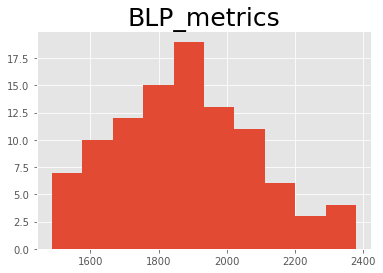

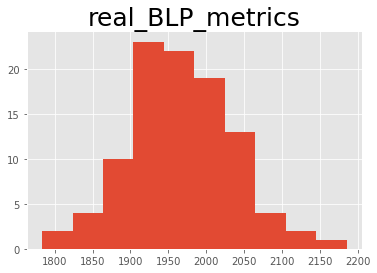

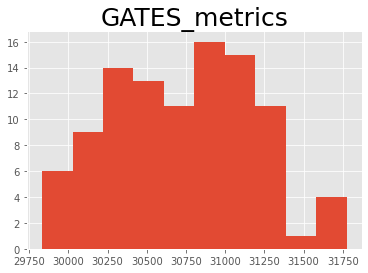

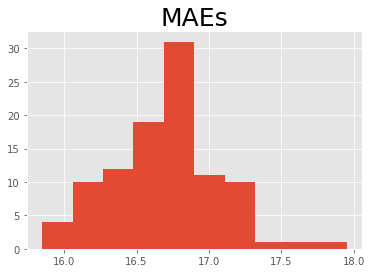

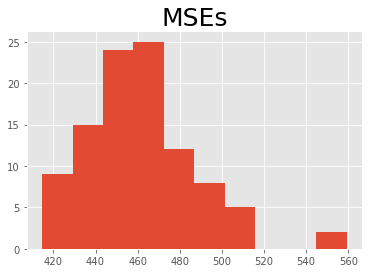

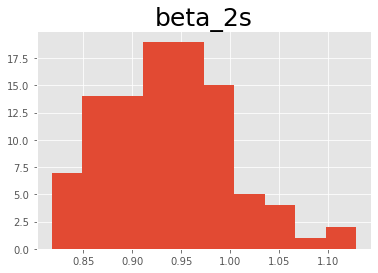

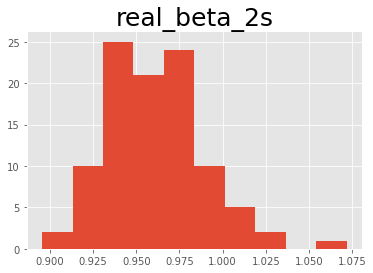

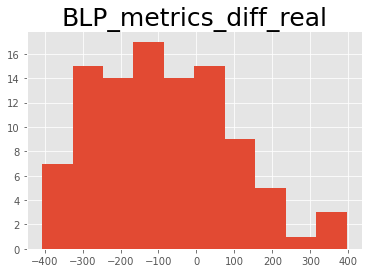

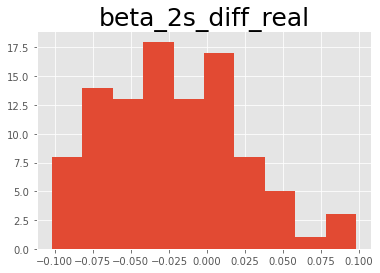

In [40]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = rf0_tune_MSE, model1 = rf1_tune_Lambda_hat, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:56<00:00,  7.17s/it]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.00000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,1884.62375,30771.171930,16.70773,466.779260,1962.347800,0.941000,0.960920
std,198.30382,501.291562,0.38003,28.054807,77.611509,0.061764,0.027475
min,1379.95700,29539.048000,15.71600,407.385000,1761.580000,0.783000,0.910000
25%,1756.23450,30504.454500,16.45825,447.138000,1907.173500,0.899500,0.942750
50%,1889.13900,30807.026500,16.65850,462.469000,1968.914000,0.937000,0.956500
75%,2017.26500,31084.149500,16.98000,483.284500,2013.876750,0.987250,0.979750
max,2398.74800,31852.484000,17.93700,562.395000,2175.548000,1.078000,1.023000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,114.178,100.460,127.787,105.584,101.073,110.188
G2,154.510,146.747,162.202,150.417,149.587,151.241
G3,168.937,161.732,176.088,170.618,169.923,171.340
G4,187.055,178.547,195.580,193.074,192.098,194.055
G5,231.035,217.250,244.806,239.194,235.330,243.031


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,114.178,100.460,127.787,105.584,101.073,110.188
x1,0.980,0.832,1.129,1.042,0.894,1.191
x2,-2.150,-2.437,-1.864,-2.234,-2.522,-1.944
x3,10.509,10.287,10.730,10.350,10.137,10.563
x4,10.814,10.487,11.128,10.837,10.535,11.142
x5,38.171,37.397,38.934,38.300,37.522,39.062
x6,-6.988,-7.915,-6.061,-6.993,-7.905,-6.081
x7,0.532,0.228,0.835,0.254,-0.064,0.568
x8,0.368,0.302,0.433,0.393,0.326,0.460
x9,-1.018,-1.144,-0.891,-0.969,-1.096,-0.842


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,231.035,217.250,244.806,239.194,235.330,243.031
x1,0.967,0.816,1.117,0.934,0.785,1.082
x2,-1.907,-2.209,-1.605,-1.867,-2.161,-1.572
x3,11.083,10.862,11.303,11.492,11.278,11.707
x4,5.769,5.444,6.108,5.867,5.530,6.200
x5,28.996,28.179,29.831,29.265,28.434,30.104
x6,-7.880,-8.546,-7.212,-7.310,-8.042,-6.576
x7,-2.990,-3.217,-2.757,-2.793,-3.028,-2.560
x8,0.623,0.566,0.679,0.624,0.568,0.679
x9,-1.048,-1.177,-0.917,-1.035,-1.167,-0.902


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,117.246,97.898,136.661,133.337,127.310,139.447
x1,-0.010,-0.222,0.201,-0.108,-0.320,0.104
x2,0.246,-0.170,0.660,0.352,-0.065,0.768
x3,0.566,0.257,0.875,1.135,0.833,1.436
x4,-5.011,-5.479,-4.542,-4.970,-5.423,-4.517
x5,-9.147,-10.297,-7.985,-9.025,-10.164,-7.886
x6,-0.891,-2.059,0.261,-0.309,-1.469,0.845
x7,-3.535,-3.918,-3.153,-3.044,-3.440,-2.651
x8,0.254,0.168,0.340,0.227,0.141,0.313
x9,-0.039,-0.222,0.146,-0.062,-0.246,0.120


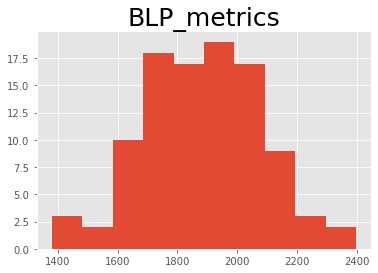

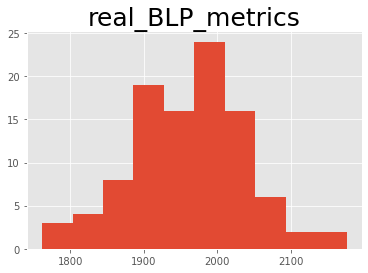

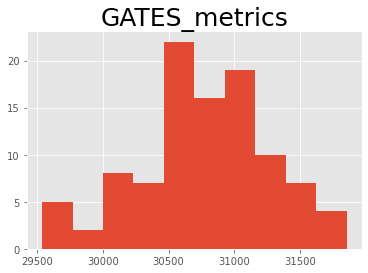

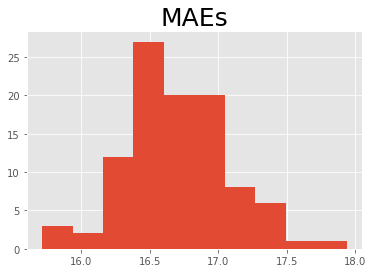

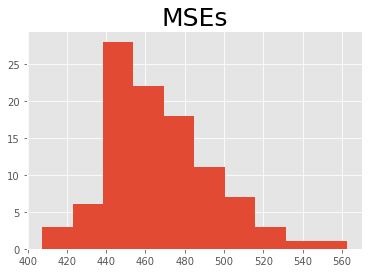

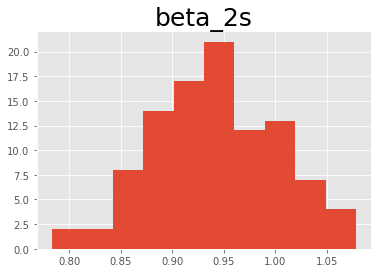

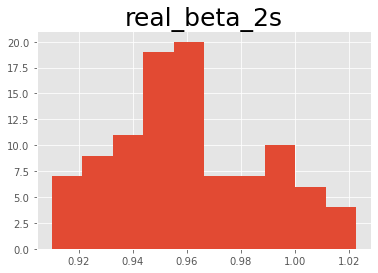

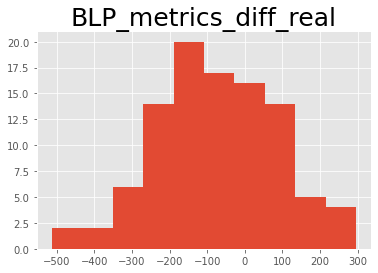

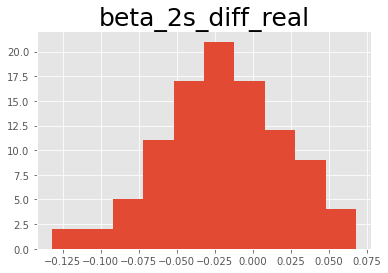

In [41]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = rf0_tune_MSE, model1 = rf1_tune_MSE, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:35<00:00,  5.76s/it]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1859.908120,30744.548950,16.796110,469.345290,1961.370420,0.926600,0.951880
std,183.879209,460.292269,0.348127,26.273692,80.040578,0.059793,0.026243
min,1182.024000,29442.875000,15.914000,418.663000,1810.167000,0.686000,0.869000
25%,1780.736500,30406.096500,16.529000,447.476750,1911.330250,0.892500,0.933750
50%,1871.299000,30755.264000,16.798000,467.725000,1952.004000,0.927000,0.949500
75%,1966.392000,31041.303500,17.048000,485.489500,2001.789500,0.967750,0.969500
max,2269.558000,31704.572000,17.670000,532.834000,2164.646000,1.058000,1.019000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,114.223,100.404,127.656,105.655,101.041,110.260
G2,155.223,147.411,162.948,150.428,149.611,151.267
G3,169.239,161.761,176.626,170.565,169.856,171.266
G4,186.841,178.769,195.244,192.973,192.002,193.949
G5,230.200,216.539,243.904,238.986,235.091,242.811


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,114.223,100.404,127.656,105.655,101.041,110.260
x1,1.004,0.857,1.153,1.047,0.899,1.197
x2,-2.122,-2.412,-1.833,-2.202,-2.490,-1.913
x3,10.512,10.288,10.731,10.363,10.150,10.576
x4,10.786,10.456,11.108,10.827,10.526,11.132
x5,38.141,37.383,38.900,38.322,37.540,39.091
x6,-6.965,-7.902,-6.036,-7.031,-7.949,-6.099
x7,0.525,0.219,0.831,0.257,-0.057,0.574
x8,0.369,0.304,0.434,0.392,0.324,0.459
x9,-1.013,-1.142,-0.887,-0.967,-1.096,-0.840


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,230.200,216.539,243.904,238.986,235.091,242.811
x1,0.974,0.824,1.124,0.953,0.804,1.102
x2,-1.920,-2.218,-1.614,-1.867,-2.164,-1.571
x3,11.078,10.856,11.301,11.483,11.264,11.700
x4,5.753,5.428,6.081,5.846,5.514,6.178
x5,29.016,28.185,29.850,29.255,28.433,30.070
x6,-7.894,-8.556,-7.231,-7.316,-8.034,-6.598
x7,-2.984,-3.214,-2.752,-2.792,-3.029,-2.555
x8,0.626,0.570,0.682,0.622,0.567,0.678
x9,-1.060,-1.191,-0.929,-1.046,-1.179,-0.914


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,116.298,97.066,135.601,133.314,127.330,139.295
x1,-0.022,-0.235,0.189,-0.099,-0.309,0.112
x2,0.209,-0.208,0.625,0.347,-0.067,0.760
x3,0.560,0.251,0.869,1.119,0.811,1.425
x4,-5.025,-5.485,-4.568,-4.983,-5.433,-4.534
x5,-9.159,-10.288,-8.031,-9.041,-10.175,-7.898
x6,-0.904,-2.091,0.264,-0.298,-1.460,0.869
x7,-3.508,-3.884,-3.126,-3.055,-3.444,-2.666
x8,0.263,0.177,0.348,0.229,0.144,0.316
x9,-0.044,-0.227,0.139,-0.065,-0.250,0.120


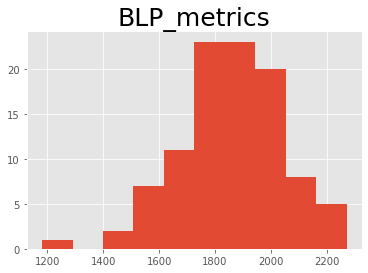

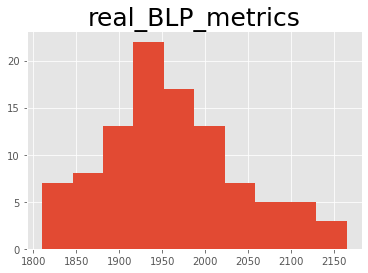

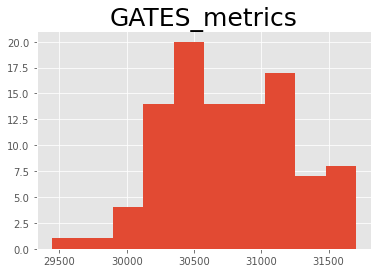

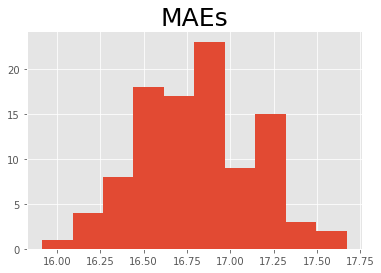

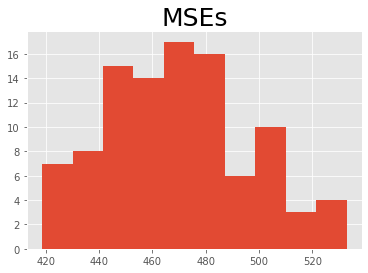

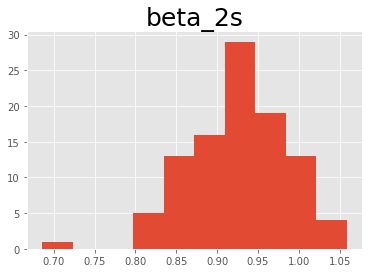

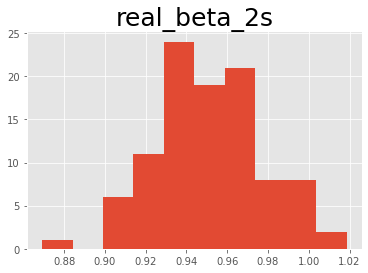

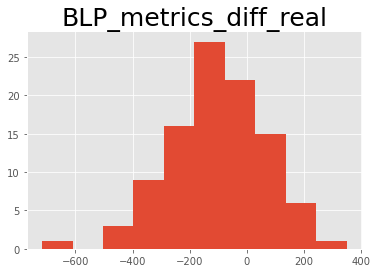

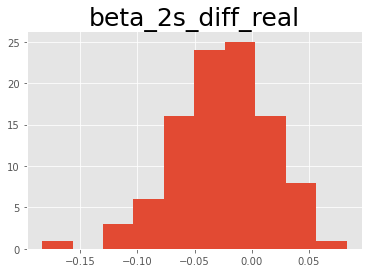

In [42]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = rf0_tune_MSE, model1 = RandomForestRegressor(), 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

### b) Tuning Elastic Net: tuning 1 model, first model for B(X) is obtained from tuning MSE

# IF RUNNING THE WHOLE FILE, COMMENT THE CELL BELOW!!!

In [43]:
# WRITE DOWN THE OPTIMAL PARAMETERS HERE!!!!
# IF RUNNING THE WHOLE FILE, COMMENT THIS CELL!!!!
# elast0_tune_MSE = ElasticNet(alpha=0.1, 
#                           l1_ratio=1.0)

# elast1_tune_MSE = ElasticNet(alpha = 0.1, 
#                             l1_ratio = 1.0)

### 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)

In [44]:
# 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)
elast0_tune_MSE1 = ElasticNet(alpha = elast0_tune_MSE.get_params()['alpha'], 
                          l1_ratio = elast0_tune_MSE.get_params()['l1_ratio']
)

elast0_tune_MSE2 = ElasticNet(alpha = elast0_tune_MSE.get_params()['alpha'], 
                          l1_ratio = elast0_tune_MSE.get_params()['l1_ratio']
)

elast0_tune_MSE3 = ElasticNet(alpha = elast0_tune_MSE.get_params()['alpha'], 
                          l1_ratio = elast0_tune_MSE.get_params()['l1_ratio']
)

## Creating 3 OOF samples where D = 0 to join them with OOF samples where D = 1 to imitate the whole OOF sample in general (B sample), on which all metrics are calculated!!!!! And making corresponding fit of rf0_tune_MSE on all data apart from OOF!!!
### For B(X) model is already tuned (minimising MSE), so no need to fit every time later, since optimizing hyperparameters are known (can fit once in the cell below for each fold)!!!!!

In [45]:
# all three models in the list will be fitted and used 
    # to predict B(X) for OOF immitation of B sample later!!!!
list_models0 = [elast0_tune_MSE1, elast0_tune_MSE2, elast0_tune_MSE3]
OOF0_samples = []
scalers0 = []

i = 0
for train_index, test_index in KFold(n_splits = 3).split(df_A_0):
    tr_index = train_index
    te_index = test_index 
    
    df_train = df_A_0.iloc[tr_index].copy()
    df_test = df_A_0.iloc[te_index].copy()
    X_train = df_train[x_cols]
    y_train = df_train['y']
    X_pred = df_test[x_cols]
    # MinMaxSCALER!!!!! (as mentioned in paper)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scalers0.append(scaler)
    # optimal MSE tuned model for D = 0 but fit on 'train' A data where D = 0
    model = list_models0[i]
    model.fit(scaler.transform(X_train), y_train)
    
    # appending needed data
    OOF0_samples.append(df_test)
    # fitted scalers
    scalers0.append(scaler)
    i += 1

In [46]:
# tuning based on CV Lambda_hat score, done BackBone!
init_lambda_hat = 0
best_lambda_hat = init_lambda_hat
best_params = {}
i = 0

for alpha in tqdm_notebook([0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    for l1_ratio in tqdm(np.linspace(0, 1, 11)):
        
        rf_sup = ElasticNet(alpha = alpha,
                                l1_ratio = l1_ratio)

        cur_lambda_hat = lambda_hat_tuning_CV(model1 = rf_sup, df1 = df_A_1, 
                                                x_cols = x_cols, list_models0 = list_models0, 
                                                OOF0_samples = OOF0_samples, scalers0 = scalers0)
        if cur_lambda_hat > best_lambda_hat: 
            i += 1
            best_lambda_hat = cur_lambda_hat
            best_params['alpha'] = alpha
            best_params['l1_ratio'] = l1_ratio
            if i % 2 == 0:
                print(best_lambda_hat)
                print(best_params)

C:\Users\052\AppData\Local\Temp\ipykernel_16184\2629798658.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for alpha in tqdm_notebook([0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):


  0%|          | 0/9 [00:00<?, ?it/s]


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.865e+05, tolerance: 2.663e+02 Linear regression models with nul

C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.305e+05, tolerance: 3.016e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the Line

 45%|█████████████████████████████████████▋                                             | 5/11 [00:00<00:00,  8.11it/s]D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.865e+05, tolerance: 2.663e+02 Linear regression models with null

D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.061e+05, tolerance: 2.820e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.line

C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.305e+05, tolerance: 3.016e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the Line

1496.4995340589724
{'alpha': 0.0001, 'l1_ratio': 1.0}



  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.212e+05, tolerance: 2.663e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.979e+05, tolerance: 3.016e+02 Linear regression models with null wei

1497.0731734328983
{'alpha': 0.01, 'l1_ratio': 1.0}



  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.074e+06, tolerance: 2.663e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+06, tolerance: 3.016e+02 Linear regression models with null wei


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 17.67it/s]

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e+06, tolerance: 2.663e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features o

In [47]:
best_params, best_lambda_hat

({'alpha': 0.1, 'l1_ratio': 1.0}, 1498.2217338263479)

In [48]:
elast1_tune_Lambda_hat = ElasticNet(alpha = best_params['alpha'] , 
                                   l1_ratio = best_params['l1_ratio'])

### General (non-pairwise) comparison of 3 ElasticNet specifications: target tuned, MSE tuned, default!!

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.25it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,1683.193910,30199.968750,20.277100,693.248070,1723.04255,0.949670,0.960940
std,152.060463,546.342768,0.423882,27.179028,74.28885,0.062628,0.034928
min,1257.019000,29027.476000,19.368000,633.576000,1572.74100,0.779000,0.880000
25%,1578.787000,29811.845250,19.993000,675.397000,1665.13250,0.911000,0.935750
50%,1694.021000,30165.889000,20.271500,691.686000,1715.20350,0.946500,0.959000
75%,1782.933000,30519.110750,20.478750,708.319250,1771.35300,0.993500,0.980000
max,2083.563000,31689.241000,21.179000,779.276000,1892.23600,1.134000,1.081000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,117.955,104.216,131.581,105.964,101.424,110.486
G2,151.629,141.926,161.342,150.562,149.714,151.416
G3,169.330,159.396,179.009,170.641,169.942,171.352
G4,187.255,176.545,198.148,192.917,191.942,193.900
G5,225.126,210.398,239.842,238.757,234.916,242.623


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,117.955,104.216,131.581,105.964,101.424,110.486
x1,1.344,1.203,1.487,1.048,0.898,1.198
x2,-1.990,-2.279,-1.699,-2.211,-2.498,-1.924
x3,10.574,10.357,10.791,10.357,10.142,10.571
x4,11.541,11.186,11.900,10.816,10.518,11.118
x5,39.677,38.835,40.525,38.270,37.498,39.038
x6,-7.277,-8.182,-6.361,-6.988,-7.901,-6.082
x7,0.412,0.113,0.717,0.254,-0.061,0.567
x8,0.381,0.314,0.447,0.396,0.330,0.463
x9,-1.026,-1.152,-0.899,-0.970,-1.097,-0.843


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,225.126,210.398,239.842,238.757,234.916,242.623
x1,0.614,0.469,0.760,0.947,0.799,1.097
x2,-2.060,-2.358,-1.764,-1.857,-2.157,-1.561
x3,11.391,11.174,11.608,11.477,11.261,11.694
x4,5.905,5.626,6.184,5.883,5.544,6.215
x5,29.274,28.507,30.042,29.265,28.430,30.116
x6,-6.620,-7.271,-5.963,-7.291,-8.011,-6.567
x7,-3.152,-3.350,-2.950,-2.800,-3.037,-2.562
x8,0.618,0.562,0.674,0.624,0.569,0.679
x9,-1.037,-1.169,-0.907,-1.047,-1.178,-0.913


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,106.918,86.870,127.065,132.947,126.928,138.906
x1,-0.732,-0.936,-0.528,-0.100,-0.311,0.112
x2,-0.084,-0.500,0.336,0.352,-0.061,0.763
x3,0.817,0.510,1.124,1.128,0.822,1.434
x4,-5.642,-6.092,-5.182,-4.938,-5.384,-4.480
x5,-10.445,-11.570,-9.296,-8.990,-10.122,-7.858
x6,0.586,-0.551,1.740,-0.287,-1.465,0.875
x7,-3.573,-3.937,-3.211,-3.035,-3.431,-2.648
x8,0.237,0.149,0.325,0.227,0.141,0.314
x9,-0.017,-0.199,0.164,-0.073,-0.255,0.111


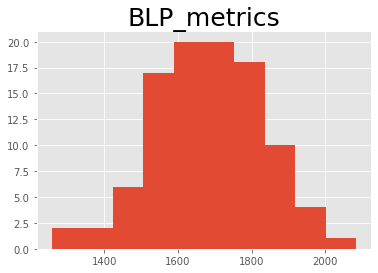

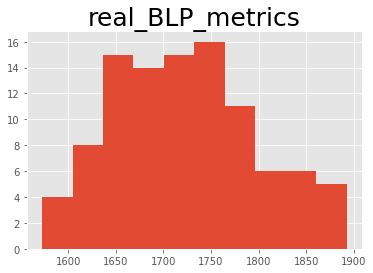

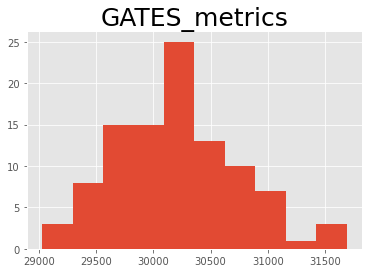

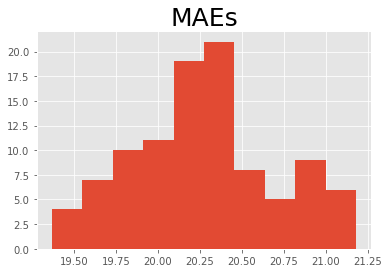

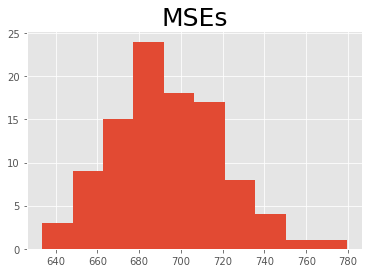

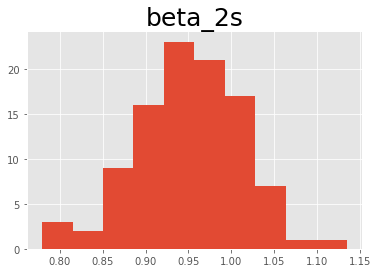

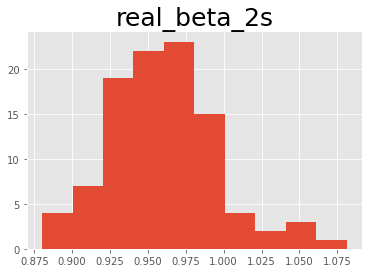

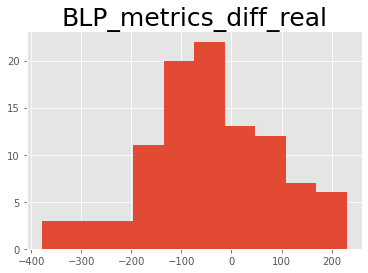

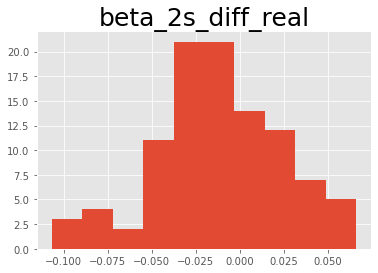

In [49]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = elast0_tune_MSE, model1 = elast1_tune_Lambda_hat, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.23it/s]


Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,1739.800050,30201.999540,20.20612,689.531660,1747.287450,0.975540,0.977710
std,175.084684,552.515837,0.55040,35.998206,63.440308,0.076898,0.041053
min,1271.164000,28972.861000,19.14200,615.458000,1567.702000,0.780000,0.880000
25%,1619.870500,29938.454500,19.85075,668.520000,1703.595000,0.924750,0.946750
50%,1733.954000,30252.024500,20.20700,688.173000,1752.820500,0.970500,0.977000
75%,1868.820250,30615.793500,20.58325,714.420500,1791.471250,1.019500,0.999000
max,2125.897000,31471.567000,21.67300,803.174000,1887.548000,1.156000,1.096000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,116.866,102.645,130.600,105.489,100.877,110.040
G2,151.147,141.082,161.176,150.351,149.513,151.185
G3,169.221,159.390,178.983,170.531,169.788,171.289
G4,187.492,176.494,198.599,192.924,191.951,193.912
G5,224.817,210.670,239.708,239.041,235.226,242.900


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,116.866,102.645,130.600,105.489,100.877,110.040
x1,1.350,1.208,1.494,1.043,0.894,1.191
x2,-1.983,-2.273,-1.689,-2.214,-2.500,-1.929
x3,10.572,10.354,10.791,10.367,10.151,10.581
x4,11.557,11.205,11.914,10.826,10.519,11.134
x5,39.691,38.872,40.519,38.260,37.483,39.026
x6,-7.279,-8.190,-6.373,-6.993,-7.902,-6.069
x7,0.416,0.111,0.714,0.265,-0.045,0.578
x8,0.385,0.317,0.453,0.397,0.330,0.463
x9,-1.017,-1.145,-0.890,-0.973,-1.101,-0.846


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,224.817,210.670,239.708,239.041,235.226,242.900
x1,0.607,0.465,0.749,0.945,0.797,1.095
x2,-2.091,-2.387,-1.793,-1.872,-2.166,-1.578
x3,11.417,11.205,11.630,11.480,11.265,11.697
x4,5.911,5.632,6.197,5.866,5.542,6.191
x5,29.307,28.552,30.068,29.267,28.461,30.097
x6,-6.680,-7.341,-6.023,-7.308,-8.027,-6.588
x7,-3.156,-3.356,-2.960,-2.799,-3.033,-2.564
x8,0.614,0.558,0.671,0.622,0.567,0.676
x9,-1.038,-1.168,-0.910,-1.040,-1.173,-0.910


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,108.230,88.463,128.864,133.626,127.616,139.519
x1,-0.744,-0.947,-0.541,-0.093,-0.305,0.117
x2,-0.129,-0.540,0.288,0.345,-0.066,0.759
x3,0.839,0.534,1.148,1.116,0.809,1.423
x4,-5.626,-6.085,-5.178,-4.967,-5.419,-4.517
x5,-10.421,-11.536,-9.295,-8.980,-10.113,-7.862
x6,0.645,-0.487,1.764,-0.283,-1.432,0.869
x7,-3.561,-3.923,-3.195,-3.065,-3.458,-2.673
x8,0.231,0.143,0.318,0.227,0.141,0.312
x9,-0.021,-0.204,0.161,-0.076,-0.260,0.108


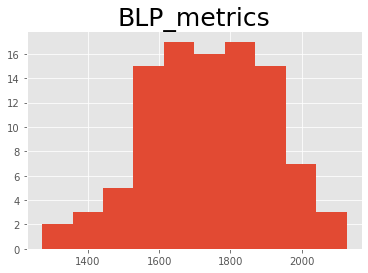

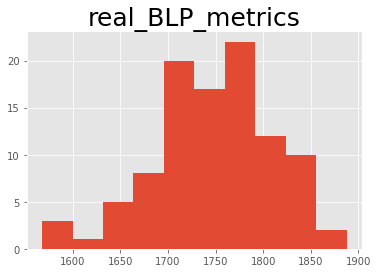

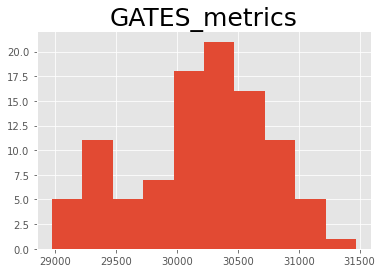

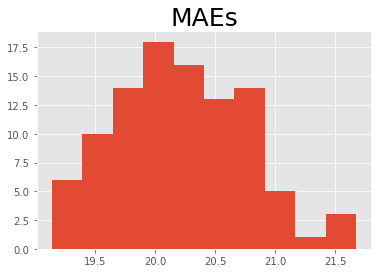

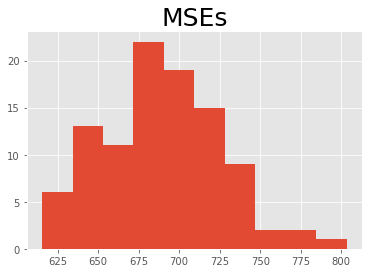

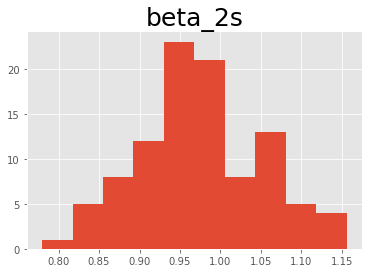

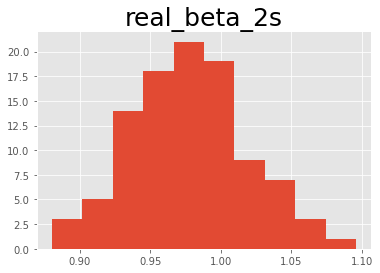

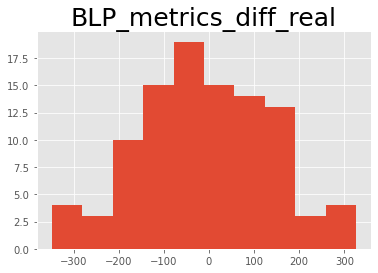

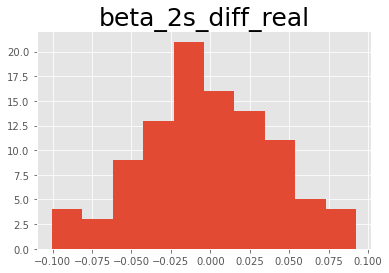

In [50]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = elast0_tune_MSE, model1 = elast1_tune_MSE, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.09it/s]


Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1112.929260,29805.147730,34.742130,2256.636300,1174.968730,12.845300,13.187080
std,176.730544,523.869402,0.456157,68.822513,124.072337,1.921084,1.511734
min,501.438000,28794.457000,33.567000,2059.279000,769.568000,7.360000,9.117000
25%,975.133250,29395.433250,34.495750,2217.706750,1095.671000,11.555500,12.143750
50%,1120.511500,29843.966000,34.698500,2264.392000,1184.243500,12.745500,13.133500
75%,1224.278000,30144.816750,35.052500,2294.900250,1252.156750,13.957250,14.110750
max,1481.024000,31198.166000,35.795000,2419.225000,1448.099000,17.711000,17.284000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,125.818,112.300,139.286,105.431,100.871,109.978
G2,151.670,140.914,162.485,150.493,149.675,151.348
G3,171.150,161.092,181.367,170.596,169.873,171.330
G4,184.147,172.859,195.951,192.887,191.921,193.834
G5,216.224,200.832,231.445,239.069,235.191,242.801


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,125.818,112.300,139.286,105.431,100.871,109.978
x1,1.653,1.522,1.785,1.045,0.895,1.196
x2,-1.952,-2.243,-1.659,-2.202,-2.492,-1.915
x3,10.260,10.055,10.467,10.364,10.149,10.579
x4,11.916,11.602,12.236,10.815,10.507,11.121
x5,41.288,40.563,42.028,38.262,37.497,39.047
x6,-6.205,-7.077,-5.331,-7.089,-7.993,-6.185
x7,-0.810,-1.166,-0.466,0.281,-0.033,0.589
x8,0.354,0.282,0.426,0.393,0.325,0.459
x9,-0.993,-1.119,-0.869,-0.967,-1.095,-0.840


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,216.224,200.832,231.445,239.069,235.191,242.801
x1,0.303,0.176,0.430,0.940,0.790,1.090
x2,-1.942,-2.239,-1.640,-1.854,-2.150,-1.558
x3,11.692,11.488,11.896,11.477,11.260,11.698
x4,5.819,5.549,6.088,5.863,5.527,6.189
x5,27.959,27.294,28.626,29.292,28.450,30.131
x6,-5.986,-6.706,-5.270,-7.261,-7.980,-6.543
x7,-2.152,-2.348,-1.963,-2.797,-3.029,-2.566
x8,0.746,0.706,0.787,0.624,0.569,0.679
x9,-1.020,-1.152,-0.889,-1.041,-1.173,-0.912


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,90.814,70.227,111.172,133.506,127.477,139.476
x1,-1.332,-1.517,-1.147,-0.106,-0.317,0.106
x2,0.026,-0.389,0.447,0.360,-0.049,0.777
x3,1.417,1.124,1.711,1.117,0.812,1.426
x4,-6.094,-6.508,-5.673,-4.950,-5.399,-4.495
x5,-13.339,-14.339,-12.354,-8.985,-10.111,-7.869
x6,0.217,-0.916,1.344,-0.199,-1.372,0.972
x7,-1.332,-1.734,-0.937,-3.068,-3.461,-2.674
x8,0.396,0.313,0.480,0.231,0.145,0.317
x9,-0.025,-0.207,0.156,-0.078,-0.261,0.107


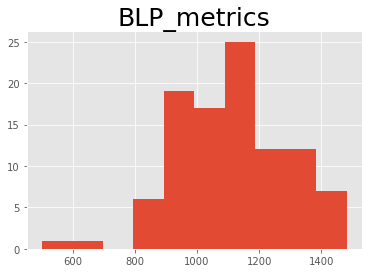

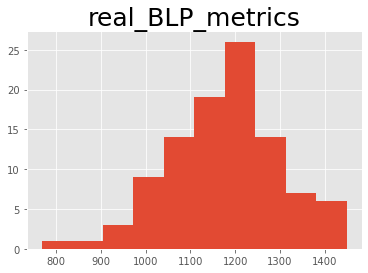

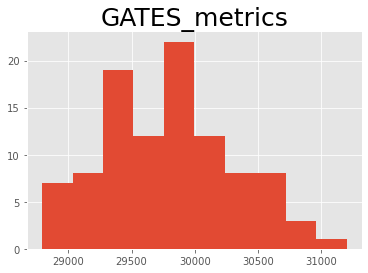

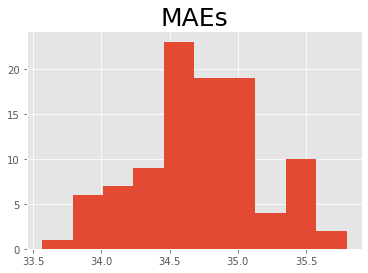

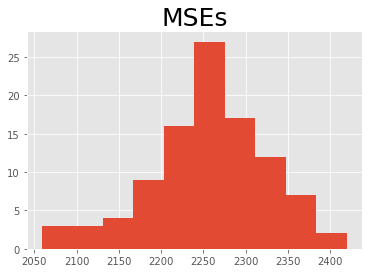

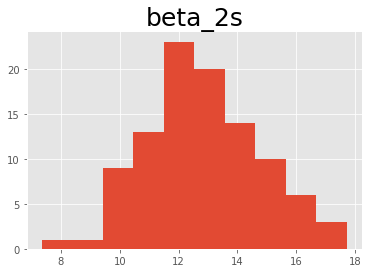

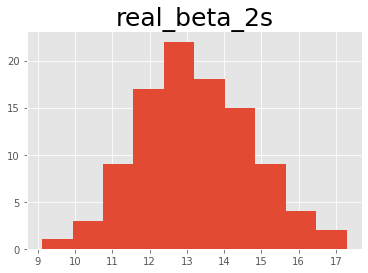

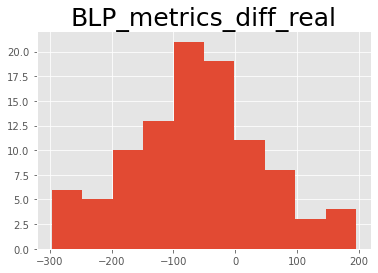

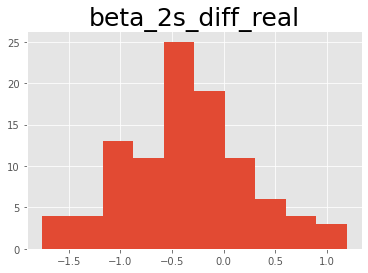

In [51]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = elast0_tune_MSE, model1 = ElasticNet(), 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

### c) Tuning Lgbm: tuning 1 model, first model for B(X) is obtained from tuning MSE

# IF RUNNING THE WHOLE FILE, COMMENT THE CELL BELOW!!!

In [52]:
# WRITE DOWN THE OPTIMAL PARAMETERS HERE!!!!
# IF RUNNING THE WHOLE FILE, COMMENT THIS CELL!!!!
# lgbm0_tune_MSE = LGBMRegressor(colsample_bytree=1, 
#                                min_child_weight=0.0001, 
#                                min_split_gain=0,
#                                n_estimators=50, 
#                                num_leaves=20, 
#                                silent=False)

# lgbm1_tune_MSE = LGBMRegressor(colsample_bytree=0.8, 
#                                learning_rate=0.05, 
#                                min_child_weight=0.0001,
#                                min_split_gain=0,
#                                n_estimators=200, 
#                                num_leaves=20, 
#                                silent=False)

### 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)

In [53]:
# 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)
lgbm0_tune_MSE1 = LGBMRegressor(colsample_bytree = lgbm0_tune_MSE.get_params()['colsample_bytree'], 
                               min_child_weight = lgbm0_tune_MSE.get_params()['min_child_weight'], 
                               min_split_gain = lgbm0_tune_MSE.get_params()['min_split_gain'],
                               n_estimators = lgbm0_tune_MSE.get_params()['n_estimators'], 
                               num_leaves = lgbm0_tune_MSE.get_params()['num_leaves'],
                               learning_rate = lgbm0_tune_MSE.get_params()['learning_rate'],
                               silent = lgbm0_tune_MSE.get_params()['silent'])

lgbm0_tune_MSE2 = LGBMRegressor(colsample_bytree = lgbm0_tune_MSE.get_params()['colsample_bytree'], 
                               min_child_weight = lgbm0_tune_MSE.get_params()['min_child_weight'], 
                               min_split_gain = lgbm0_tune_MSE.get_params()['min_split_gain'],
                               n_estimators = lgbm0_tune_MSE.get_params()['n_estimators'], 
                               num_leaves = lgbm0_tune_MSE.get_params()['num_leaves'], 
                               learning_rate = lgbm0_tune_MSE.get_params()['learning_rate'],
                               silent = lgbm0_tune_MSE.get_params()['silent'])

lgbm0_tune_MSE3 = LGBMRegressor(colsample_bytree = lgbm0_tune_MSE.get_params()['colsample_bytree'], 
                               min_child_weight = lgbm0_tune_MSE.get_params()['min_child_weight'], 
                               min_split_gain = lgbm0_tune_MSE.get_params()['min_split_gain'],
                               n_estimators = lgbm0_tune_MSE.get_params()['n_estimators'], 
                               num_leaves = lgbm0_tune_MSE.get_params()['num_leaves'], 
                               learning_rate = lgbm0_tune_MSE.get_params()['learning_rate'],
                               silent = lgbm0_tune_MSE.get_params()['silent'])

## Creating 3 OOF samples where D = 0 to join them with OOF samples where D = 1 to imitate the whole OOF sample in general (B sample), on which all metrics are calculated!!!!! And making corresponding fit of rf0_tune_MSE on all data apart from OOF!!!
### For B(X) model is already tuned (minimising MSE), so no need to fit every time later, since optimizing hyperparameters are known (can fit once in the cell below for each fold)!!!!!

In [54]:
# all three models in the list will be fitted and used 
    # to predict B(X) for OOF immitation of B sample later!!!!
list_models0 = [lgbm0_tune_MSE1, lgbm0_tune_MSE2, lgbm0_tune_MSE3]
OOF0_samples = []
scalers0 = []

i = 0
for train_index, test_index in KFold(n_splits = 3).split(df_A_0):
    tr_index = train_index
    te_index = test_index 
    
    df_train = df_A_0.iloc[tr_index].copy()
    df_test = df_A_0.iloc[te_index].copy()
    X_train = df_train[x_cols]
    y_train = df_train['y']
    X_pred = df_test[x_cols]
    # MinMaxSCALER!!!!! (as mentioned in paper)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scalers0.append(scaler)
    # optimal MSE tuned model for D = 0 but fit on 'train' A data where D = 0
    model = list_models0[i]
    model.fit(scaler.transform(X_train), y_train)
    
    # appending needed data
    OOF0_samples.append(df_test)
    # fitted scalers
    scalers0.append(scaler)
    i += 1

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 18
[LightGBM] [Info] Start training from score 4.087562
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 989, number of used features: 18
[LightGBM] [Info] Start training from score 6.046827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 989, number of used features: 18
[LightGBM] [Info] Start 

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [55]:
# tuning based on CV Lambda_hat score, done BackBone!
init_lambda_hat = 0
best_lambda_hat = init_lambda_hat
best_params = {}
i = 0

for colsample_bytree in tqdm_notebook([0.5, 0.8, 1]):
    for learning_rate in tqdm([0.05, 0.1, 0.5]):
        for num_leaves in tqdm([20, 31, 50]):
            for min_split_gain in [0, 0.01, 0.1, 1]:
                for min_child_weight in [0.0001, 0.001, 0.01]:
                    for n_estimators in [50, 100, 200]:
                        
                        rf_sup = LGBMRegressor(colsample_bytree = colsample_bytree, 
                                               learning_rate = learning_rate, 
                                               num_leaves = num_leaves, 
                                               min_split_gain = min_split_gain, 
                                               min_child_weight = min_child_weight, 
                                               n_estimators = n_estimators)

                        cur_lambda_hat = lambda_hat_tuning_CV(model1 = rf_sup, df1 = df_A_1, 
                                                      x_cols = x_cols, list_models0 = list_models0, 
                                                      OOF0_samples = OOF0_samples, scalers0 = scalers0)
                        
                        if cur_lambda_hat > best_lambda_hat: 
                            i += 1
                            best_lambda_hat = cur_lambda_hat
                            best_params['colsample_bytree'] = colsample_bytree
                            best_params['learning_rate'] = learning_rate
                            best_params['num_leaves'] = num_leaves
                            best_params['min_split_gain'] = min_split_gain
                            best_params['min_child_weight'] = min_child_weight
                            best_params['n_estimators'] = n_estimators
                            if i % 2 == 0:
                                print(best_lambda_hat)
                                print(best_params)

C:\Users\052\AppData\Local\Temp\ipykernel_16184\1387240265.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for colsample_bytree in tqdm_notebook([0.5, 0.8, 1]):


  0%|          | 0/3 [00:00<?, ?it/s]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1356.2432374856762
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'num_leaves': 20, 'min_split_gain': 0, 'min_child_weight': 0.0001, 'n_estimators': 100}




 33%|████████████████████████████                                                        | 1/3 [00:16<00:32, 16.35s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:34<00:17, 17.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:52<00:00, 17.41s/it]

 33%|████████████████████████████                                                        | 1/3 [00:52<01:44, 52.23s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:16<00:32, 16.40s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:34<00:17, 17.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:52<00:00, 17.50s/it]

 67%|█████████████████████████

1422.9626492255484
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'num_leaves': 20, 'min_split_gain': 0, 'min_child_weight': 0.0001, 'n_estimators': 200}




 33%|████████████████████████████                                                        | 1/3 [00:17<00:35, 17.64s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:36<00:18, 18.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:56<00:00, 18.82s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [01:52<00:56, 56.12s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:16<00:32, 16.19s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:33<00:16, 16.96s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.98s/it]

100%|█████████████████████████

In [56]:
best_params, best_lambda_hat

({'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'num_leaves': 20,
  'min_split_gain': 0,
  'min_child_weight': 0.0001,
  'n_estimators': 200},
 1422.9626492255484)

In [57]:
lgbm1_tune_Lambda_hat = LGBMRegressor(colsample_bytree = best_params['colsample_bytree'], 
                                               learning_rate = best_params['learning_rate'], 
                                               num_leaves = best_params['num_leaves'], 
                                               min_split_gain = best_params['min_split_gain'], 
                                               min_child_weight = best_params['min_child_weight'], 
                                               n_estimators = best_params['n_estimators'])

### General (non-pairwise) comparison of 3 lgbm specifications: target tuned, MSE tuned, default!!

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 3.859951


  1%|▊                                                                                 | 1/100 [00:00<01:03,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 18
[LightGBM] [Info] Start training from score 4.281520


  2%|█▋                                                                                | 2/100 [00:01<01:02,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 18
[LightGBM] [Info] Start training from score 4.510141


  3%|██▍                                                                               | 3/100 [00:01<01:00,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 2.785627


  4%|███▎                                                                              | 4/100 [00:02<00:59,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 18
[LightGBM] [Info] Start training from score 4.123194


  5%|████                                                                              | 5/100 [00:03<00:59,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 18
[LightGBM] [Info] Start training from score 4.674009


  6%|████▉                                                                             | 6/100 [00:03<00:58,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1475, number of used features: 18
[LightGBM] [Info] Start training from score 4.369749


  7%|█████▋                                                                            | 7/100 [00:04<00:57,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1472, number of used features: 18
[LightGBM] [Info] Start training from score 3.738391


  8%|██████▌                                                                           | 8/100 [00:04<00:57,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 18
[LightGBM] [Info] Start training from score 4.334272


  9%|███████▍                                                                          | 9/100 [00:05<00:56,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 18
[LightGBM] [Info] Start training from score 5.254805


 10%|████████                                                                         | 10/100 [00:06<00:55,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 4.306849


 11%|████████▉                                                                        | 11/100 [00:06<00:54,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 4.996518


 12%|█████████▋                                                                       | 12/100 [00:07<00:54,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 18
[LightGBM] [Info] Start training from score 4.288849


 13%|██████████▌                                                                      | 13/100 [00:08<00:53,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1436, number of used features: 18
[LightGBM] [Info] Start training from score 4.539311


 14%|███████████▎                                                                     | 14/100 [00:08<00:52,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1481, number of used features: 18
[LightGBM] [Info] Start training from score 4.662872


 15%|████████████▏                                                                    | 15/100 [00:09<00:52,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 18
[LightGBM] [Info] Start training from score 3.547919


 16%|████████████▉                                                                    | 16/100 [00:09<00:51,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 3.908662


 17%|█████████████▊                                                                   | 17/100 [00:10<00:51,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1472, number of used features: 18
[LightGBM] [Info] Start training from score 4.371197


 18%|██████████████▌                                                                  | 18/100 [00:11<00:50,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1480, number of used features: 18
[LightGBM] [Info] Start training from score 3.993357


 19%|███████████████▍                                                                 | 19/100 [00:11<00:49,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 4.647244


 20%|████████████████▏                                                                | 20/100 [00:12<00:49,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 18
[LightGBM] [Info] Start training from score 3.737273


 21%|█████████████████                                                                | 21/100 [00:12<00:48,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 3.582174


 22%|█████████████████▊                                                               | 22/100 [00:13<00:48,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 18
[LightGBM] [Info] Start training from score 3.402161


 23%|██████████████████▋                                                              | 23/100 [00:14<00:47,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1486, number of used features: 18
[LightGBM] [Info] Start training from score 3.910650


 24%|███████████████████▍                                                             | 24/100 [00:14<00:46,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 18
[LightGBM] [Info] Start training from score 5.745355


 25%|████████████████████▎                                                            | 25/100 [00:15<00:45,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 18
[LightGBM] [Info] Start training from score 4.692641


 26%|█████████████████████                                                            | 26/100 [00:15<00:44,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 18
[LightGBM] [Info] Start training from score 2.125555


 27%|█████████████████████▊                                                           | 27/100 [00:16<00:44,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 3.736830


 28%|██████████████████████▋                                                          | 28/100 [00:17<00:44,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 5.176567


 29%|███████████████████████▍                                                         | 29/100 [00:17<00:43,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 18
[LightGBM] [Info] Start training from score 4.069947


 30%|████████████████████████▎                                                        | 30/100 [00:18<00:42,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1461, number of used features: 18
[LightGBM] [Info] Start training from score 2.299123


 31%|█████████████████████████                                                        | 31/100 [00:19<00:41,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 18
[LightGBM] [Info] Start training from score 3.582652


 32%|█████████████████████████▉                                                       | 32/100 [00:19<00:41,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 4.262873


 33%|██████████████████████████▋                                                      | 33/100 [00:20<00:40,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 4.176213


 34%|███████████████████████████▌                                                     | 34/100 [00:20<00:40,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1508, number of used features: 18
[LightGBM] [Info] Start training from score 3.699412


 35%|████████████████████████████▎                                                    | 35/100 [00:21<00:40,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1490, number of used features: 18
[LightGBM] [Info] Start training from score 3.067757


 36%|█████████████████████████████▏                                                   | 36/100 [00:22<00:39,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 18
[LightGBM] [Info] Start training from score 5.186910


 37%|█████████████████████████████▉                                                   | 37/100 [00:22<00:38,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 18
[LightGBM] [Info] Start training from score 2.876541


 38%|██████████████████████████████▊                                                  | 38/100 [00:23<00:38,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1492, number of used features: 18
[LightGBM] [Info] Start training from score 3.635019


 39%|███████████████████████████████▌                                                 | 39/100 [00:24<00:38,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 18
[LightGBM] [Info] Start training from score 4.196718


 40%|████████████████████████████████▍                                                | 40/100 [00:24<00:37,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 5.181357


 41%|█████████████████████████████████▏                                               | 41/100 [00:25<00:36,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 4.035550


 42%|██████████████████████████████████                                               | 42/100 [00:25<00:35,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 2.966257


 43%|██████████████████████████████████▊                                              | 43/100 [00:26<00:35,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 18
[LightGBM] [Info] Start training from score 4.620214


 44%|███████████████████████████████████▋                                             | 44/100 [00:27<00:34,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 18
[LightGBM] [Info] Start training from score 4.219515


 45%|████████████████████████████████████▍                                            | 45/100 [00:27<00:33,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 18
[LightGBM] [Info] Start training from score 4.068138


 46%|█████████████████████████████████████▎                                           | 46/100 [00:28<00:32,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 18
[LightGBM] [Info] Start training from score 2.423384


 47%|██████████████████████████████████████                                           | 47/100 [00:28<00:32,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 3.615989


 48%|██████████████████████████████████████▉                                          | 48/100 [00:29<00:31,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 3.111523


 49%|███████████████████████████████████████▋                                         | 49/100 [00:30<00:31,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 3.932969


 50%|████████████████████████████████████████▌                                        | 50/100 [00:30<00:30,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 2.984527


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:31<00:29,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 18
[LightGBM] [Info] Start training from score 5.010770


 52%|██████████████████████████████████████████                                       | 52/100 [00:31<00:29,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 18
[LightGBM] [Info] Start training from score 4.746592


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:32<00:28,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1490, number of used features: 18
[LightGBM] [Info] Start training from score 4.565826


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:33<00:28,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 18
[LightGBM] [Info] Start training from score 3.536607


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:33<00:27,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 18
[LightGBM] [Info] Start training from score 4.595250


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:34<00:26,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1486, number of used features: 18
[LightGBM] [Info] Start training from score 3.469103


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:35<00:26,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1475, number of used features: 18
[LightGBM] [Info] Start training from score 2.312877


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:35<00:25,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 18
[LightGBM] [Info] Start training from score 3.838257


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:36<00:24,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1511, number of used features: 18
[LightGBM] [Info] Start training from score 3.972525


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:36<00:24,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 18
[LightGBM] [Info] Start training from score 3.514216


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:37<00:23,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 18
[LightGBM] [Info] Start training from score 4.433434


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:38<00:23,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 3.121566


 63%|███████████████████████████████████████████████████                              | 63/100 [00:38<00:22,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 3.696905


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:39<00:22,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 18
[LightGBM] [Info] Start training from score 4.966777


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:39<00:21,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1475, number of used features: 18
[LightGBM] [Info] Start training from score 5.611054


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:40<00:20,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 2.992144


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:41<00:20,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 3.807774


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:41<00:19,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1499, number of used features: 18
[LightGBM] [Info] Start training from score 2.892913


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:42<00:19,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 18
[LightGBM] [Info] Start training from score 3.326577


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:42<00:18,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 3.722814


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:43<00:17,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1457, number of used features: 18
[LightGBM] [Info] Start training from score 3.094148


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:44<00:17,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 5.974254


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:44<00:16,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 2.564010


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:45<00:15,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1491, number of used features: 18
[LightGBM] [Info] Start training from score 2.087895


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:46<00:15,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 18
[LightGBM] [Info] Start training from score 4.147119


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:46<00:14,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 18
[LightGBM] [Info] Start training from score 4.287582


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:47<00:14,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1495, number of used features: 18
[LightGBM] [Info] Start training from score 3.041065


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:47<00:13,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 4.443349


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:48<00:12,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 18
[LightGBM] [Info] Start training from score 4.360440


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:49<00:12,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 2.964341


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:49<00:11,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1449, number of used features: 18
[LightGBM] [Info] Start training from score 2.769899


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:50<00:10,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 18
[LightGBM] [Info] Start training from score 3.843795


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:50<00:10,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 5.504311


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:51<00:09,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 18
[LightGBM] [Info] Start training from score 5.111583


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:52<00:09,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 4.035099


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:52<00:08,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 18
[LightGBM] [Info] Start training from score 3.938110


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:53<00:07,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 4.327426


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:53<00:07,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1480, number of used features: 18
[LightGBM] [Info] Start training from score 2.422880


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:54<00:06,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 18
[LightGBM] [Info] Start training from score 2.699594


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:55<00:06,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 18
[LightGBM] [Info] Start training from score 4.648963


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:55<00:05,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 18
[LightGBM] [Info] Start training from score 3.887601


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:56<00:04,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1452, number of used features: 18
[LightGBM] [Info] Start training from score 3.244981


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:56<00:04,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 4.788505


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:57<00:03,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 18
[LightGBM] [Info] Start training from score 2.505558


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:58<00:03,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 18
[LightGBM] [Info] Start training from score 3.517123


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:58<00:02,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 4.905288


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:59<00:01,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1480, number of used features: 18
[LightGBM] [Info] Start training from score 4.597618


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:59<00:01,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1504, number of used features: 18
[LightGBM] [Info] Start training from score 3.980928


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:00<00:00,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1452, number of used features: 18
[LightGBM] [Info] Start training from score 4.316201


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,1869.007390,30760.692150,17.317920,489.946210,1936.09474,0.930870,0.947560
std,142.409285,398.959474,0.310471,20.289233,67.44706,0.047447,0.022837
min,1417.071000,29709.115000,16.637000,440.609000,1693.68900,0.799000,0.892000
25%,1779.451250,30514.365750,17.103250,478.188250,1900.14875,0.901000,0.934500
50%,1864.397500,30774.669500,17.297000,489.274500,1933.79450,0.931000,0.947000
75%,1986.314750,31017.374500,17.500000,503.670750,1979.12100,0.966250,0.958250
max,2176.934000,31847.379000,18.280000,567.252000,2121.75000,1.032000,1.008000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,114.169,101.454,126.706,105.674,101.055,110.207
G2,155.364,147.796,163.156,150.389,149.555,151.237
G3,169.283,161.842,176.832,170.568,169.856,171.280
G4,187.266,179.160,195.452,192.917,191.915,193.921
G5,229.754,217.060,242.436,238.823,235.035,242.657


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,114.169,101.454,126.706,105.674,101.055,110.207
x1,1.012,0.862,1.161,1.049,0.898,1.199
x2,-2.200,-2.491,-1.912,-2.220,-2.509,-1.929
x3,10.396,10.178,10.614,10.367,10.152,10.581
x4,10.863,10.550,11.178,10.827,10.520,11.130
x5,38.285,37.535,39.028,38.275,37.511,39.037
x6,-7.118,-8.035,-6.187,-7.037,-7.955,-6.122
x7,0.413,0.103,0.718,0.270,-0.045,0.584
x8,0.383,0.316,0.449,0.394,0.327,0.462
x9,-0.992,-1.125,-0.862,-0.975,-1.102,-0.847


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,229.754,217.060,242.436,238.823,235.035,242.657
x1,0.963,0.811,1.115,0.942,0.794,1.091
x2,-1.843,-2.139,-1.543,-1.866,-2.164,-1.569
x3,11.244,11.023,11.467,11.480,11.262,11.696
x4,5.836,5.502,6.167,5.872,5.539,6.205
x5,29.061,28.208,29.914,29.273,28.439,30.103
x6,-7.740,-8.439,-7.043,-7.308,-8.019,-6.583
x7,-2.937,-3.171,-2.702,-2.797,-3.031,-2.564
x8,0.612,0.555,0.668,0.623,0.567,0.678
x9,-1.056,-1.186,-0.925,-1.045,-1.177,-0.914


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,115.841,97.974,133.586,133.251,127.244,139.288
x1,-0.048,-0.261,0.162,-0.117,-0.327,0.094
x2,0.358,-0.055,0.771,0.345,-0.069,0.763
x3,0.831,0.523,1.143,1.123,0.814,1.426
x4,-4.990,-5.451,-4.541,-4.949,-5.404,-4.500
x5,-9.270,-10.375,-8.146,-9.045,-10.169,-7.908
x6,-0.661,-1.819,0.472,-0.287,-1.452,0.884
x7,-3.344,-3.738,-2.961,-3.068,-3.457,-2.673
x8,0.228,0.140,0.316,0.230,0.142,0.316
x9,-0.052,-0.239,0.131,-0.075,-0.258,0.110


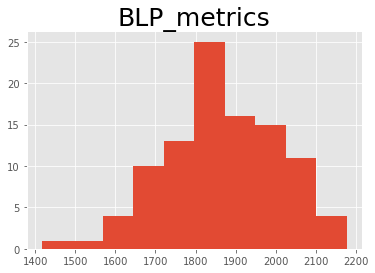

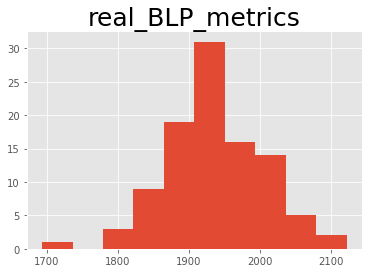

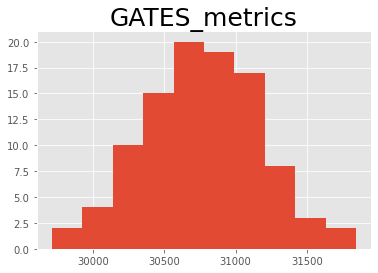

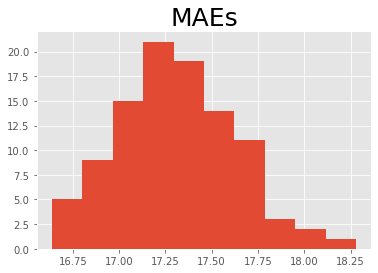

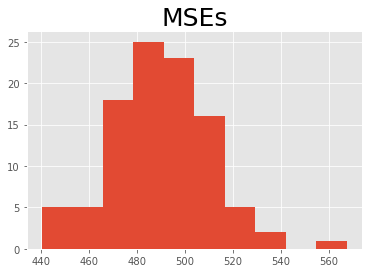

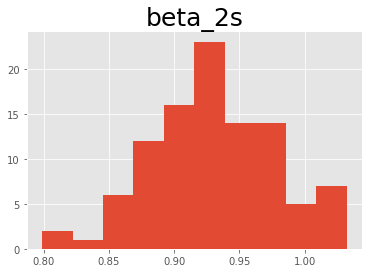

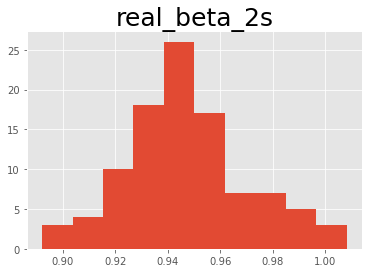

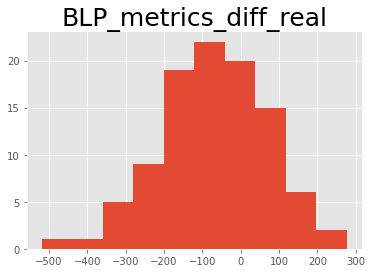

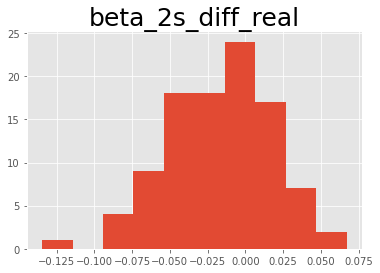

In [58]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = lgbm0_tune_MSE, model1 = lgbm1_tune_Lambda_hat, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 5.448449
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 18
[LightGBM] [Info] Start training from score 171.306150


  1%|▊                                                                                 | 1/100 [00:00<01:03,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 18
[LightGBM] [Info] Start training from score 3.525114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 18
[LightGBM] [Info] Start training from score 170.523050


  2%|█▋                                                                                | 2/100 [00:01<01:03,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 4.068937
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 18
[LightGBM] [Info] Start training from score 172.114080


  3%|██▍                                                                               | 3/100 [00:01<01:01,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 2.951024
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 18
[LightGBM] [Info] Start training from score 169.750653


  4%|███▎                                                                              | 4/100 [00:02<01:01,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 3.639592
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 169.825548


  5%|████                                                                              | 5/100 [00:03<01:01,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1475, number of used features: 18
[LightGBM] [Info] Start training from score 3.881623
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 925, number of used features: 18
[LightGBM] [Info] Start training from score 170.868568


  6%|████▉                                                                             | 6/100 [00:03<00:59,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1486, number of used features: 18
[LightGBM] [Info] Start training from score 2.380181
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 914, number of used features: 18
[LightGBM] [Info] Start training from score 170.596241


  7%|█████▋                                                                            | 7/100 [00:04<00:58,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 3.719852
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 18
[LightGBM] [Info] Start training from score 170.294927


  8%|██████▌                                                                           | 8/100 [00:05<00:57,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 18
[LightGBM] [Info] Start training from score 4.439268
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 940, number of used features: 18
[LightGBM] [Info] Start training from score 172.305310


  9%|███████▍                                                                          | 9/100 [00:05<00:56,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 4.634893
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 18
[LightGBM] [Info] Start training from score 170.454067


 10%|████████                                                                         | 10/100 [00:06<00:56,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 4.248690
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 171.249035


 11%|████████▉                                                                        | 11/100 [00:06<00:55,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 3.129431
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 18
[LightGBM] [Info] Start training from score 172.633761


 12%|█████████▋                                                                       | 12/100 [00:07<00:54,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 18
[LightGBM] [Info] Start training from score 5.303985
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 18
[LightGBM] [Info] Start training from score 170.489147


 13%|██████████▌                                                                      | 13/100 [00:08<00:53,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 18
[LightGBM] [Info] Start training from score 5.046105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 897, number of used features: 18
[LightGBM] [Info] Start training from score 173.758128


 14%|███████████▎                                                                     | 14/100 [00:08<00:52,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 18
[LightGBM] [Info] Start training from score 4.453162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 18
[LightGBM] [Info] Start training from score 171.391459


 15%|████████████▏                                                                    | 15/100 [00:09<00:52,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 3.982293
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 171.161254


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
 16%|████████████▉                                                                    | 16/100 [00:10<00:52,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning(

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1469, number of used features: 18
[LightGBM] [Info] Start training from score 3.353822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 931, number of used features: 18
[LightGBM] [Info] Start training from score 170.181034


 17%|█████████████▊                                                                   | 17/100 [00:10<00:51,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 4.075643
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 911, number of used features: 18
[LightGBM] [Info] Start training from score 169.912211


 18%|██████████████▌                                                                  | 18/100 [00:11<00:50,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 4.512353
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 18
[LightGBM] [Info] Start training from score 170.155509


 19%|███████████████▍                                                                 | 19/100 [00:11<00:50,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 18
[LightGBM] [Info] Start training from score 4.305284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 900, number of used features: 18
[LightGBM] [Info] Start training from score 171.849540


 20%|████████████████▏                                                                | 20/100 [00:12<00:49,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1492, number of used features: 18
[LightGBM] [Info] Start training from score 4.432605
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 908, number of used features: 18
[LightGBM] [Info] Start training from score 171.094330


 21%|█████████████████                                                                | 21/100 [00:13<00:49,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 4.538436
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 18
[LightGBM] [Info] Start training from score 171.728841


 22%|█████████████████▊                                                               | 22/100 [00:13<00:48,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 4.228317
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 171.733004


 23%|██████████████████▋                                                              | 23/100 [00:14<00:47,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1469, number of used features: 18
[LightGBM] [Info] Start training from score 3.630491
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 931, number of used features: 18
[LightGBM] [Info] Start training from score 171.254334


 24%|███████████████████▍                                                             | 24/100 [00:14<00:46,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1472, number of used features: 18
[LightGBM] [Info] Start training from score 3.116548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 18
[LightGBM] [Info] Start training from score 172.582370


 25%|████████████████████▎                                                            | 25/100 [00:15<00:45,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 18
[LightGBM] [Info] Start training from score 3.661518
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 945, number of used features: 18
[LightGBM] [Info] Start training from score 170.513252


 26%|█████████████████████                                                            | 26/100 [00:16<00:46,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1495, number of used features: 18
[LightGBM] [Info] Start training from score 3.367481
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 905, number of used features: 18
[LightGBM] [Info] Start training from score 171.796908


 27%|█████████████████████▊                                                           | 27/100 [00:16<00:45,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 4.582457
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 18
[LightGBM] [Info] Start training from score 170.500587


 28%|██████████████████████▋                                                          | 28/100 [00:17<00:44,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 3.843219
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 18
[LightGBM] [Info] Start training from score 172.332482


 29%|███████████████████████▍                                                         | 29/100 [00:18<00:43,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 18
[LightGBM] [Info] Start training from score 5.813373
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 918, number of used features: 18
[LightGBM] [Info] Start training from score 172.353815


 30%|████████████████████████▎                                                        | 30/100 [00:18<00:43,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1499, number of used features: 18
[LightGBM] [Info] Start training from score 3.224776
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 901, number of used features: 18
[LightGBM] [Info] Start training from score 172.816472


 31%|█████████████████████████                                                        | 31/100 [00:19<00:43,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1449, number of used features: 18
[LightGBM] [Info] Start training from score 5.657301
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 951, number of used features: 18
[LightGBM] [Info] Start training from score 171.668814


 32%|█████████████████████████▉                                                       | 32/100 [00:19<00:42,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1495, number of used features: 18
[LightGBM] [Info] Start training from score 5.378006
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 905, number of used features: 18
[LightGBM] [Info] Start training from score 172.055498


 33%|██████████████████████████▋                                                      | 33/100 [00:20<00:41,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 4.908474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 18
[LightGBM] [Info] Start training from score 171.120935


 34%|███████████████████████████▌                                                     | 34/100 [00:21<00:41,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 3.763332
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 18
[LightGBM] [Info] Start training from score 171.486374


 35%|████████████████████████████▎                                                    | 35/100 [00:21<00:40,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1475, number of used features: 18
[LightGBM] [Info] Start training from score 3.816390
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 925, number of used features: 18
[LightGBM] [Info] Start training from score 172.166937


 36%|█████████████████████████████▏                                                   | 36/100 [00:22<00:39,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 18
[LightGBM] [Info] Start training from score 3.389781
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 18
[LightGBM] [Info] Start training from score 171.917277


 37%|█████████████████████████████▉                                                   | 37/100 [00:23<00:38,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 5.411697
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 18
[LightGBM] [Info] Start training from score 169.754674


 38%|██████████████████████████████▊                                                  | 38/100 [00:23<00:38,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1513, number of used features: 18
[LightGBM] [Info] Start training from score 5.294503
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 887, number of used features: 18
[LightGBM] [Info] Start training from score 172.574213


 39%|███████████████████████████████▌                                                 | 39/100 [00:24<00:37,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1492, number of used features: 18
[LightGBM] [Info] Start training from score 3.300662
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 908, number of used features: 18
[LightGBM] [Info] Start training from score 170.812927


 40%|████████████████████████████████▍                                                | 40/100 [00:24<00:36,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 3.585036
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 18
[LightGBM] [Info] Start training from score 172.428561


 41%|█████████████████████████████████▏                                               | 41/100 [00:25<00:36,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 18
[LightGBM] [Info] Start training from score 4.566155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 947, number of used features: 18
[LightGBM] [Info] Start training from score 169.652451


 42%|██████████████████████████████████                                               | 42/100 [00:26<00:35,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 6.188368
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 18
[LightGBM] [Info] Start training from score 169.887330


 43%|██████████████████████████████████▊                                              | 43/100 [00:26<00:35,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 4.030910
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 18
[LightGBM] [Info] Start training from score 170.492606


 44%|███████████████████████████████████▋                                             | 44/100 [00:27<00:34,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1491, number of used features: 18
[LightGBM] [Info] Start training from score 4.647093
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 909, number of used features: 18
[LightGBM] [Info] Start training from score 172.797246


 45%|████████████████████████████████████▍                                            | 45/100 [00:27<00:33,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 3.245713
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 18
[LightGBM] [Info] Start training from score 169.232477


 46%|█████████████████████████████████████▎                                           | 46/100 [00:28<00:33,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 3.315885
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 18
[LightGBM] [Info] Start training from score 170.947979


 47%|██████████████████████████████████████                                           | 47/100 [00:29<00:32,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1451, number of used features: 18
[LightGBM] [Info] Start training from score 5.691621
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 949, number of used features: 18
[LightGBM] [Info] Start training from score 171.344412


 48%|██████████████████████████████████████▉                                          | 48/100 [00:29<00:31,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 18
[LightGBM] [Info] Start training from score 2.145336
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 18
[LightGBM] [Info] Start training from score 170.629256


 49%|███████████████████████████████████████▋                                         | 49/100 [00:30<00:31,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1457, number of used features: 18
[LightGBM] [Info] Start training from score 5.302910


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 943, number of used features: 18
[LightGBM] [Info] Start training from score 172.998462


 50%|████████████████████████████████████████▌                                        | 50/100 [00:31<00:31,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 3.017209
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 18
[LightGBM] [Info] Start training from score 170.300555


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:31<00:30,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 18
[LightGBM] [Info] Start training from score 3.863163
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 18
[LightGBM] [Info] Start training from score 171.531363


 52%|██████████████████████████████████████████                                       | 52/100 [00:32<00:29,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1512, number of used features: 18
[LightGBM] [Info] Start training from score 4.751678


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 888, number of used features: 18
[LightGBM] [Info] Start training from score 168.641388


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:32<00:28,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1505, number of used features: 18
[LightGBM] [Info] Start training from score 4.029777
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 18
[LightGBM] [Info] Start training from score 170.440705


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
 54%|███████████████████████████████████████████▋                                     | 54/100 [00:33<00:28,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning(

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1495, number of used features: 18
[LightGBM] [Info] Start training from score 4.719017
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 905, number of used features: 18
[LightGBM] [Info] Start training from score 170.031943


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:34<00:27,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 4.425483
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 930, number of used features: 18
[LightGBM] [Info] Start training from score 172.391669


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:34<00:27,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1472, number of used features: 18
[LightGBM] [Info] Start training from score 4.093053
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 18
[LightGBM] [Info] Start training from score 170.873125


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:35<00:26,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1445, number of used features: 18
[LightGBM] [Info] Start training from score 3.377999
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 955, number of used features: 18
[LightGBM] [Info] Start training from score 170.433980


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:35<00:25,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 4.279478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 937, number of used features: 18
[LightGBM] [Info] Start training from score 169.461378


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:36<00:24,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 3.780218
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 18
[LightGBM] [Info] Start training from score 170.071844


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:37<00:24,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 18
[LightGBM] [Info] Start training from score 2.955070
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 899, number of used features: 18
[LightGBM] [Info] Start training from score 171.481155


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:37<00:23,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1451, number of used features: 18
[LightGBM] [Info] Start training from score 4.805499
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 949, number of used features: 18
[LightGBM] [Info] Start training from score 168.420421


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:38<00:23,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 18
[LightGBM] [Info] Start training from score 3.711227
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 918, number of used features: 18
[LightGBM] [Info] Start training from score 170.678123


 63%|███████████████████████████████████████████████████                              | 63/100 [00:38<00:22,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 18
[LightGBM] [Info] Start training from score 4.084254
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 898, number of used features: 18
[LightGBM] [Info] Start training from score 170.728134


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:39<00:22,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 5.648289
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 18
[LightGBM] [Info] Start training from score 169.695536


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:40<00:21,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 4.639556
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 18
[LightGBM] [Info] Start training from score 172.410415


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:40<00:21,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 3.352471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 917, number of used features: 18
[LightGBM] [Info] Start training from score 172.069459


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:41<00:20,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 4.019613


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 911, number of used features: 18
[LightGBM] [Info] Start training from score 171.239123


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:42<00:20,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 18
[LightGBM] [Info] Start training from score 4.276907
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 947, number of used features: 18
[LightGBM] [Info] Start training from score 170.934585


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:42<00:19,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 18
[LightGBM] [Info] Start training from score 3.598047
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 18
[LightGBM] [Info] Start training from score 169.798541


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:43<00:18,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 3.146333
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 18
[LightGBM] [Info] Start training from score 170.915559


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:43<00:17,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 4.275815
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 18
[LightGBM] [Info] Start training from score 171.893687


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:44<00:17,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 5.648904
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 18
[LightGBM] [Info] Start training from score 171.123405


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:45<00:17,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1492, number of used features: 18
[LightGBM] [Info] Start training from score 3.903915


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 908, number of used features: 18
[LightGBM] [Info] Start training from score 172.631448


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:46<00:18,  1.42it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1480, number of used features: 18
[LightGBM] [Info] Start training from score 3.926838


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 18
[LightGBM] [Info] Start training from score 171.328493


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:46<00:18,  1.38it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 18
[LightGBM] [Info] Start training from score 4.882386
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 945, number of used features: 18
[LightGBM] [Info] Start training from score 172.970137


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:47<00:17,  1.38it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 5.286964


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 18
[LightGBM] [Info] Start training from score 171.284577


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:48<00:17,  1.33it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 3.288541
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 18
[LightGBM] [Info] Start training from score 172.108953


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:49<00:15,  1.41it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1499, number of used features: 18
[LightGBM] [Info] Start training from score 3.556640
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 901, number of used features: 18
[LightGBM] [Info] Start training from score 172.177749


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:49<00:14,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 18
[LightGBM] [Info] Start training from score 4.485392
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 899, number of used features: 18
[LightGBM] [Info] Start training from score 167.381199


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:50<00:13,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 4.315119
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 169.971872


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:50<00:12,  1.54it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1461, number of used features: 18
[LightGBM] [Info] Start training from score 3.079596
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 939, number of used features: 18
[LightGBM] [Info] Start training from score 172.060267


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:51<00:11,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1472, number of used features: 18
[LightGBM] [Info] Start training from score 4.650607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 18
[LightGBM] [Info] Start training from score 171.027233


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:52<00:10,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 4.480452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 169.412662


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:52<00:10,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 18
[LightGBM] [Info] Start training from score 5.052830
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 884, number of used features: 18
[LightGBM] [Info] Start training from score 170.330530


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:53<00:09,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 18
[LightGBM] [Info] Start training from score 3.351002
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 18
[LightGBM] [Info] Start training from score 171.027932


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:53<00:08,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 18
[LightGBM] [Info] Start training from score 3.900326
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 913, number of used features: 18
[LightGBM] [Info] Start training from score 170.125512


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:54<00:08,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 18
[LightGBM] [Info] Start training from score 4.019363
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 947, number of used features: 18
[LightGBM] [Info] Start training from score 171.588139


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:55<00:07,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 1.999347
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 18
[LightGBM] [Info] Start training from score 172.373428


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:55<00:06,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1461, number of used features: 18
[LightGBM] [Info] Start training from score 3.758612
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 939, number of used features: 18
[LightGBM] [Info] Start training from score 172.593506


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:56<00:06,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 4.266320
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 18
[LightGBM] [Info] Start training from score 169.490730


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:57<00:05,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 2.965239
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 18
[LightGBM] [Info] Start training from score 171.764303


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:57<00:04,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1454, number of used features: 18
[LightGBM] [Info] Start training from score 4.307248
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 946, number of used features: 18
[LightGBM] [Info] Start training from score 171.057224


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:58<00:04,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 3.327942
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 18
[LightGBM] [Info] Start training from score 171.811771


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:58<00:03,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 18
[LightGBM] [Info] Start training from score 4.378251
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 940, number of used features: 18
[LightGBM] [Info] Start training from score 168.267438


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:59<00:03,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1497, number of used features: 18
[LightGBM] [Info] Start training from score 3.905456
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 903, number of used features: 18
[LightGBM] [Info] Start training from score 171.372521


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:00<00:02,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 3.181152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 18
[LightGBM] [Info] Start training from score 170.706737


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:00<00:01,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1469, number of used features: 18
[LightGBM] [Info] Start training from score 2.935676
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 931, number of used features: 18
[LightGBM] [Info] Start training from score 170.651538


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:01<00:01,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning(

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 4.874802
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 18
[LightGBM] [Info] Start training from score 170.709413


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:02<00:00,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 3.199682
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 18
[LightGBM] [Info] Start training from score 172.417310


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1888.915470,30843.423990,16.762770,461.317080,1964.588560,0.952200,0.971490
std,161.997743,444.235874,0.309521,20.183023,66.135818,0.050814,0.024697
min,1458.401000,29947.805000,16.187000,419.418000,1798.386000,0.805000,0.918000
25%,1764.936750,30529.356000,16.545000,446.242500,1913.157750,0.917750,0.954750
50%,1890.076500,30827.480000,16.740500,458.754000,1973.611500,0.951000,0.969000
75%,2003.304750,31149.219750,16.953500,475.251500,2012.469750,0.984250,0.988250
max,2257.734000,32003.953000,17.498000,519.315000,2084.205000,1.102000,1.051000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,113.415,101.041,125.522,105.254,100.647,109.893
G2,154.927,147.447,162.390,150.437,149.588,151.308
G3,168.929,161.376,176.379,170.456,169.754,171.204
G4,188.688,180.583,196.699,192.852,191.885,193.820
G5,230.670,217.528,243.274,239.038,235.163,242.926


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,113.415,101.041,125.522,105.254,100.647,109.893
x1,1.017,0.869,1.165,1.049,0.900,1.199
x2,-2.172,-2.464,-1.883,-2.217,-2.505,-1.927
x3,10.365,10.149,10.582,10.352,10.137,10.566
x4,10.915,10.609,11.233,10.828,10.525,11.135
x5,38.450,37.722,39.181,38.248,37.479,39.022
x6,-6.992,-7.922,-6.064,-7.075,-7.992,-6.154
x7,0.430,0.122,0.737,0.284,-0.038,0.596
x8,0.380,0.314,0.447,0.393,0.326,0.460
x9,-0.982,-1.113,-0.852,-0.963,-1.089,-0.838


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,230.670,217.528,243.274,239.038,235.163,242.926
x1,0.979,0.828,1.131,0.945,0.795,1.096
x2,-1.828,-2.127,-1.531,-1.863,-2.162,-1.565
x3,11.243,11.019,11.467,11.477,11.260,11.694
x4,5.817,5.487,6.146,5.865,5.531,6.200
x5,28.982,28.152,29.807,29.240,28.420,30.072
x6,-7.776,-8.458,-7.086,-7.271,-7.992,-6.538
x7,-2.970,-3.203,-2.729,-2.799,-3.035,-2.570
x8,0.610,0.554,0.667,0.622,0.566,0.676
x9,-1.046,-1.176,-0.917,-1.042,-1.175,-0.910


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,117.510,99.613,135.183,133.430,127.433,139.486
x1,-0.044,-0.256,0.172,-0.096,-0.306,0.114
x2,0.351,-0.070,0.765,0.343,-0.071,0.758
x3,0.878,0.574,1.187,1.125,0.820,1.434
x4,-5.093,-5.543,-4.640,-4.962,-5.411,-4.509
x5,-9.521,-10.626,-8.404,-8.999,-10.140,-7.856
x6,-0.738,-1.895,0.406,-0.146,-1.306,1.004
x7,-3.382,-3.768,-2.995,-3.059,-3.453,-2.664
x8,0.224,0.138,0.312,0.227,0.141,0.314
x9,-0.062,-0.246,0.123,-0.084,-0.267,0.099


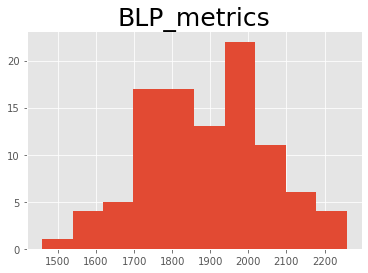

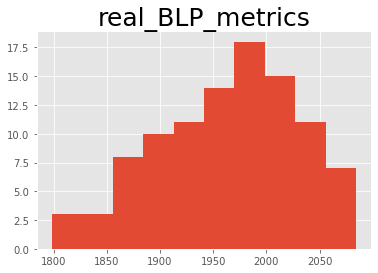

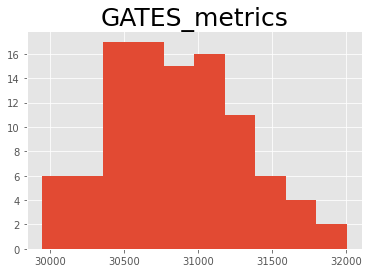

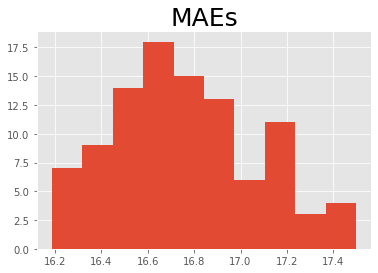

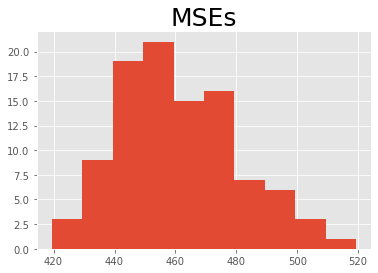

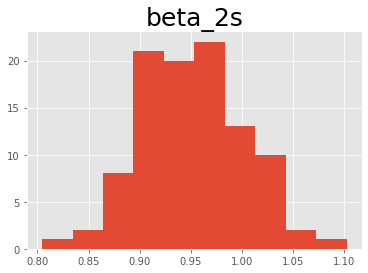

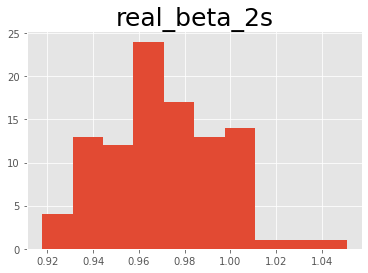

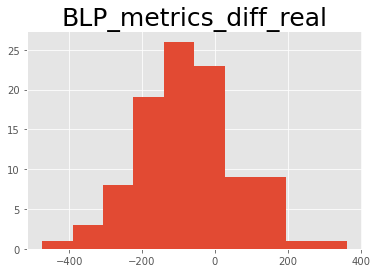

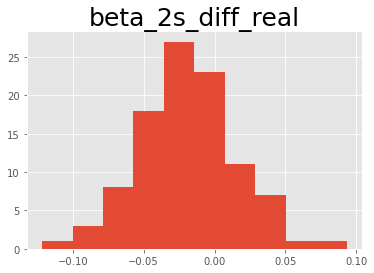

In [59]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = lgbm0_tune_MSE, model1 = lgbm1_tune_MSE, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 4.231673


  1%|▊                                                                                 | 1/100 [00:00<00:57,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 4.584935


  2%|█▋                                                                                | 2/100 [00:01<00:56,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1469, number of used features: 18
[LightGBM] [Info] Start training from score 3.337186


  3%|██▍                                                                               | 3/100 [00:01<00:55,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 18
[LightGBM] [Info] Start training from score 4.080915


  4%|███▎                                                                              | 4/100 [00:02<00:54,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1506, number of used features: 18
[LightGBM] [Info] Start training from score 4.133821


  5%|████                                                                              | 5/100 [00:02<00:53,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 3.826061


  6%|████▉                                                                             | 6/100 [00:03<00:53,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1475, number of used features: 18
[LightGBM] [Info] Start training from score 4.654673


  7%|█████▋                                                                            | 7/100 [00:03<00:53,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1445, number of used features: 18
[LightGBM] [Info] Start training from score 3.349253


  8%|██████▌                                                                           | 8/100 [00:04<00:52,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 18
[LightGBM] [Info] Start training from score 4.395768


  9%|███████▍                                                                          | 9/100 [00:05<00:52,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 3.343912


 10%|████████                                                                         | 10/100 [00:05<00:50,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 18
[LightGBM] [Info] Start training from score 3.595222


 11%|████████▉                                                                        | 11/100 [00:06<00:49,  1.80it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1444, number of used features: 18
[LightGBM] [Info] Start training from score 5.456131


 12%|█████████▋                                                                       | 12/100 [00:06<00:49,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1495, number of used features: 18
[LightGBM] [Info] Start training from score 3.952646


 13%|██████████▌                                                                      | 13/100 [00:07<00:48,  1.81it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 18
[LightGBM] [Info] Start training from score 4.325151


 14%|███████████▎                                                                     | 14/100 [00:07<00:47,  1.81it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 18
[LightGBM] [Info] Start training from score 3.682208


 15%|████████████▏                                                                    | 15/100 [00:08<00:47,  1.80it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 2.933904


 16%|████████████▉                                                                    | 16/100 [00:08<00:46,  1.81it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1472, number of used features: 18
[LightGBM] [Info] Start training from score 4.431504


 17%|█████████████▊                                                                   | 17/100 [00:09<00:45,  1.82it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1480, number of used features: 18
[LightGBM] [Info] Start training from score 4.768744


 18%|██████████████▌                                                                  | 18/100 [00:10<00:44,  1.83it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1491, number of used features: 18
[LightGBM] [Info] Start training from score 4.119150


 19%|███████████████▍                                                                 | 19/100 [00:10<00:44,  1.82it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1448, number of used features: 18
[LightGBM] [Info] Start training from score 3.837336


 20%|████████████████▏                                                                | 20/100 [00:11<00:44,  1.82it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1491, number of used features: 18
[LightGBM] [Info] Start training from score 3.674356


 21%|█████████████████                                                                | 21/100 [00:11<00:43,  1.82it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 18
[LightGBM] [Info] Start training from score 4.812557


 22%|█████████████████▊                                                               | 22/100 [00:12<00:43,  1.81it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1481, number of used features: 18
[LightGBM] [Info] Start training from score 4.477824


 23%|██████████████████▋                                                              | 23/100 [00:12<00:42,  1.81it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 3.381902


 24%|███████████████████▍                                                             | 24/100 [00:13<00:42,  1.80it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 18
[LightGBM] [Info] Start training from score 5.283164


 25%|████████████████████▎                                                            | 25/100 [00:14<00:43,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 4.259432


 26%|█████████████████████                                                            | 26/100 [00:14<00:42,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 18
[LightGBM] [Info] Start training from score 2.907836


 27%|█████████████████████▊                                                           | 27/100 [00:15<00:41,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 18
[LightGBM] [Info] Start training from score 3.215913


 28%|██████████████████████▋                                                          | 28/100 [00:15<00:40,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1486, number of used features: 18
[LightGBM] [Info] Start training from score 4.141494


 29%|███████████████████████▍                                                         | 29/100 [00:16<00:40,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 2.880039


 30%|████████████████████████▎                                                        | 30/100 [00:16<00:39,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1457, number of used features: 18
[LightGBM] [Info] Start training from score 3.693770


 31%|█████████████████████████                                                        | 31/100 [00:17<00:38,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1461, number of used features: 18
[LightGBM] [Info] Start training from score 3.736720


 32%|█████████████████████████▉                                                       | 32/100 [00:17<00:37,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1486, number of used features: 18
[LightGBM] [Info] Start training from score 4.139551


 33%|██████████████████████████▋                                                      | 33/100 [00:18<00:37,  1.80it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 18
[LightGBM] [Info] Start training from score 4.133897


 34%|███████████████████████████▌                                                     | 34/100 [00:19<00:36,  1.81it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 4.142722


 35%|████████████████████████████▎                                                    | 35/100 [00:19<00:35,  1.81it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 5.079812


 36%|█████████████████████████████▏                                                   | 36/100 [00:20<00:35,  1.82it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 4.850398


 37%|█████████████████████████████▉                                                   | 37/100 [00:20<00:34,  1.82it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1481, number of used features: 18
[LightGBM] [Info] Start training from score 4.877600


 38%|██████████████████████████████▊                                                  | 38/100 [00:21<00:34,  1.80it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 18
[LightGBM] [Info] Start training from score 4.067749


 39%|███████████████████████████████▌                                                 | 39/100 [00:21<00:33,  1.83it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1497, number of used features: 18
[LightGBM] [Info] Start training from score 4.745627


 40%|████████████████████████████████▍                                                | 40/100 [00:22<00:33,  1.81it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 5.917877


 41%|█████████████████████████████████▏                                               | 41/100 [00:22<00:32,  1.80it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 18
[LightGBM] [Info] Start training from score 3.735519


 42%|██████████████████████████████████                                               | 42/100 [00:23<00:32,  1.80it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1451, number of used features: 18
[LightGBM] [Info] Start training from score 3.870041


 43%|██████████████████████████████████▊                                              | 43/100 [00:24<00:32,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 2.570805


 44%|███████████████████████████████████▋                                             | 44/100 [00:25<00:42,  1.32it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1505, number of used features: 18
[LightGBM] [Info] Start training from score 3.650839


 45%|████████████████████████████████████▍                                            | 45/100 [00:26<00:50,  1.09it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 18
[LightGBM] [Info] Start training from score 4.640168


 46%|█████████████████████████████████████▎                                           | 46/100 [00:27<00:48,  1.12it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 4.351381


 47%|██████████████████████████████████████                                           | 47/100 [00:28<00:48,  1.10it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 18
[LightGBM] [Info] Start training from score 4.322028


 48%|██████████████████████████████████████▉                                          | 48/100 [00:29<00:45,  1.14it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 3.370249


 49%|███████████████████████████████████████▋                                         | 49/100 [00:30<00:44,  1.14it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 3.709511


 50%|████████████████████████████████████████▌                                        | 50/100 [00:30<00:42,  1.19it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 18
[LightGBM] [Info] Start training from score 2.532834


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:31<00:38,  1.29it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 18
[LightGBM] [Info] Start training from score 4.600418


 52%|██████████████████████████████████████████                                       | 52/100 [00:32<00:35,  1.37it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1491, number of used features: 18
[LightGBM] [Info] Start training from score 3.077298


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:32<00:33,  1.42it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 3.873605


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:33<00:30,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 3.909735


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:33<00:28,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1472, number of used features: 18
[LightGBM] [Info] Start training from score 3.612794


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:34<00:27,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1487, number of used features: 18
[LightGBM] [Info] Start training from score 4.191160


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:35<00:26,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1486, number of used features: 18
[LightGBM] [Info] Start training from score 5.488615


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:35<00:25,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 4.727044


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:36<00:23,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1497, number of used features: 18
[LightGBM] [Info] Start training from score 4.322409


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:36<00:23,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 2.521078


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:37<00:22,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 3.853762


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:37<00:21,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 18
[LightGBM] [Info] Start training from score 4.339926


 63%|███████████████████████████████████████████████████                              | 63/100 [00:38<00:21,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 4.760664


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:38<00:20,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 18
[LightGBM] [Info] Start training from score 4.564703


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:39<00:19,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 3.183480


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:40<00:19,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 4.614627


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:40<00:18,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1446, number of used features: 18
[LightGBM] [Info] Start training from score 3.649933


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:41<00:18,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 2.628380


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:41<00:17,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 18
[LightGBM] [Info] Start training from score 4.911621


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:42<00:17,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1497, number of used features: 18
[LightGBM] [Info] Start training from score 4.836487


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:42<00:16,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 4.129844


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:43<00:15,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1459, number of used features: 18
[LightGBM] [Info] Start training from score 3.226133


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:44<00:15,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 18
[LightGBM] [Info] Start training from score 3.810702


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:44<00:14,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 18
[LightGBM] [Info] Start training from score 4.288041


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:45<00:14,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 18
[LightGBM] [Info] Start training from score 3.566789


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:45<00:13,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 18
[LightGBM] [Info] Start training from score 3.167798


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:46<00:12,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 18
[LightGBM] [Info] Start training from score 3.890728


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:46<00:12,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 4.350613


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:47<00:11,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 2.744204


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:48<00:11,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 4.798967


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:48<00:10,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 18
[LightGBM] [Info] Start training from score 5.026527


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:49<00:10,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 3.295455


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:49<00:09,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 18
[LightGBM] [Info] Start training from score 3.420713


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:50<00:09,  1.69it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 3.413367


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:50<00:09,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 3.997119


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:51<00:08,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 4.643370


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:52<00:07,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 3.038538


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:52<00:07,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1480, number of used features: 18
[LightGBM] [Info] Start training from score 4.055051


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:53<00:06,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 2.753029


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:53<00:05,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 5.633710


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:54<00:05,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1492, number of used features: 18
[LightGBM] [Info] Start training from score 3.154138


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:54<00:04,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1491, number of used features: 18
[LightGBM] [Info] Start training from score 5.057257


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:55<00:03,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 3.481687


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:56<00:03,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1475, number of used features: 18
[LightGBM] [Info] Start training from score 4.229462


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:56<00:02,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1443, number of used features: 18
[LightGBM] [Info] Start training from score 3.828472


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:57<00:02,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 18
[LightGBM] [Info] Start training from score 5.111666


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:57<00:01,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1509, number of used features: 18
[LightGBM] [Info] Start training from score 3.546303


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:58<00:01,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 18
[LightGBM] [Info] Start training from score 3.873474


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:59<00:00,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1469, number of used features: 18
[LightGBM] [Info] Start training from score 4.365837


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1898.245730,30718.894960,17.119390,479.846640,1949.246560,0.941320,0.954100
std,150.347185,391.645801,0.332161,22.503493,75.533667,0.048256,0.024213
min,1480.518000,29785.884000,16.370000,433.296000,1725.055000,0.834000,0.882000
25%,1787.221750,30489.899000,16.832500,465.079750,1902.940500,0.907750,0.936750
50%,1896.176500,30651.527000,17.155000,475.840000,1935.755500,0.943500,0.953500
75%,1997.409250,30966.417250,17.314500,491.948250,1987.873000,0.970250,0.971250
max,2285.930000,31688.273000,17.944000,547.652000,2179.121000,1.088000,1.014000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,112.955,100.577,125.406,105.791,101.243,110.395
G2,155.296,147.893,162.964,150.419,149.570,151.241
G3,169.297,161.882,176.667,170.497,169.778,171.196
G4,186.819,178.680,195.002,192.652,191.671,193.640
G5,230.394,217.743,243.275,238.937,235.151,242.772


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,112.955,100.577,125.406,105.791,101.243,110.395
x1,1.019,0.869,1.169,1.050,0.900,1.199
x2,-2.167,-2.457,-1.877,-2.226,-2.513,-1.935
x3,10.392,10.173,10.609,10.356,10.143,10.566
x4,10.867,10.562,11.177,10.806,10.508,11.113
x5,38.256,37.519,38.990,38.279,37.508,39.050
x6,-7.004,-7.925,-6.083,-7.062,-7.979,-6.151
x7,0.393,0.089,0.701,0.261,-0.055,0.579
x8,0.388,0.321,0.455,0.394,0.327,0.461
x9,-0.996,-1.127,-0.871,-0.969,-1.097,-0.839


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,230.394,217.743,243.275,238.937,235.151,242.772
x1,0.966,0.816,1.116,0.940,0.793,1.092
x2,-1.851,-2.147,-1.552,-1.856,-2.156,-1.560
x3,11.225,11.003,11.446,11.477,11.262,11.691
x4,5.795,5.466,6.124,5.874,5.545,6.206
x5,29.030,28.187,29.880,29.226,28.399,30.050
x6,-7.771,-8.469,-7.094,-7.312,-8.030,-6.603
x7,-2.929,-3.175,-2.680,-2.791,-3.029,-2.556
x8,0.613,0.556,0.671,0.623,0.568,0.678
x9,-1.038,-1.169,-0.908,-1.042,-1.174,-0.911


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,117.379,99.539,135.255,133.216,127.353,139.097
x1,-0.059,-0.270,0.153,-0.108,-0.317,0.102
x2,0.308,-0.104,0.721,0.359,-0.057,0.771
x3,0.839,0.528,1.149,1.117,0.814,1.421
x4,-5.046,-5.503,-4.599,-4.953,-5.401,-4.496
x5,-9.226,-10.345,-8.113,-9.010,-10.151,-7.874
x6,-0.779,-1.967,0.361,-0.298,-1.459,0.874
x7,-3.320,-3.711,-2.933,-3.047,-3.444,-2.650
x8,0.227,0.141,0.315,0.231,0.145,0.318
x9,-0.042,-0.225,0.144,-0.075,-0.257,0.109


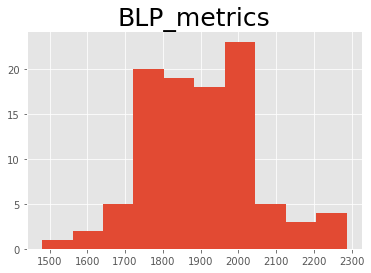

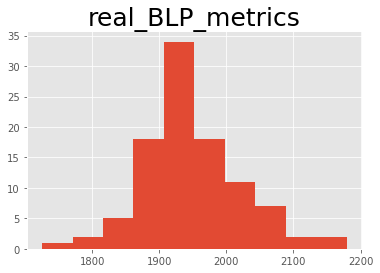

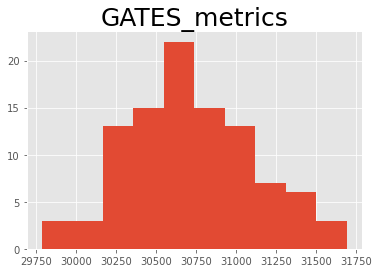

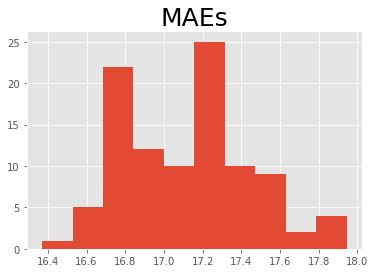

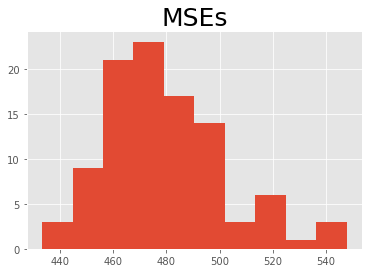

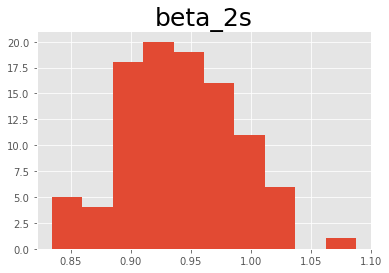

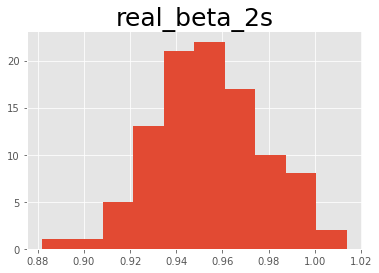

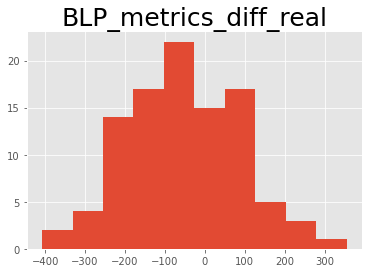

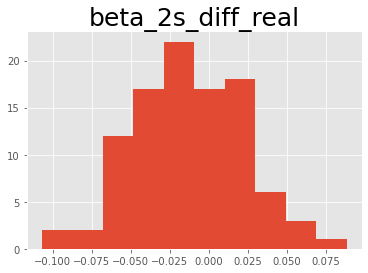

In [60]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = lgbm0_tune_MSE, model1 = LGBMRegressor(), 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

# 3) Comparing two models (MSE tune VS target tuning) , given datasplit!!! For rf, ElasticNet and lgbm

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [24:26<00:00, 14.66s/it]

Metrics table, A model metrics minus B model metrics


,BLP_metrics,GATES_metrics,MAEs,MSEs
count,100.000000,100.000000,100.000000,100.000000
mean,-1.479800,-3.851440,0.020600,0.393870
std,14.905247,63.108225,0.099766,6.305663
min,-36.087000,-117.524000,-0.267000,-20.657000
25%,-13.339750,-55.584500,-0.032000,-2.120250
50%,-1.311500,1.888000,0.018500,0.852500
75%,8.226500,35.307000,0.083750,4.061750
max,35.200000,181.529000,0.240000,14.404000


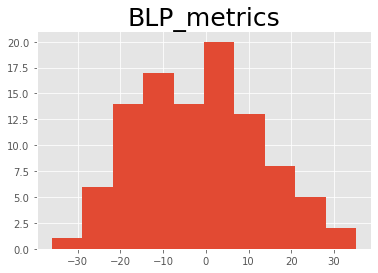

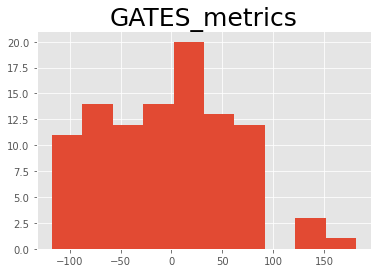

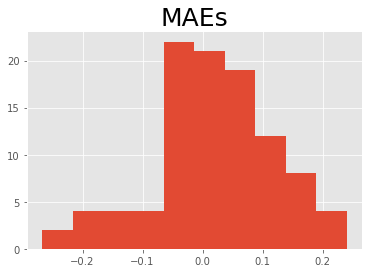

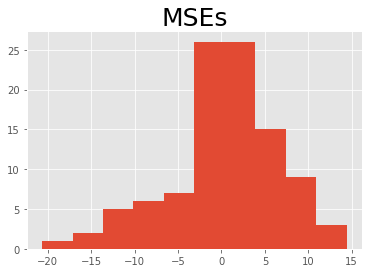

In [61]:
df_metrics =\
        term_paper_main_func_compare_two_models_PAPER_ALGO(model0_A = rf0_tune_MSE, model1_A = rf1_tune_Lambda_hat, 
                                                model0_B = rf0_tune_MSE, model1_B = rf1_tune_MSE,
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.43it/s]

Metrics table, A model metrics minus B model metrics


,BLP_metrics,GATES_metrics,MAEs,MSEs
count,100.0,100.0,100.0,100.0
mean,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0


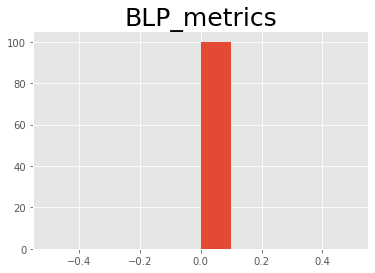

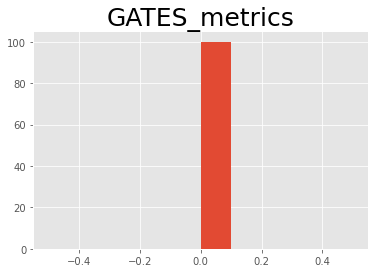

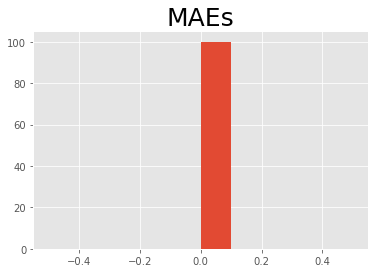

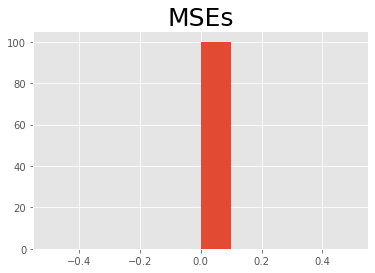

In [62]:
df_metrics =\
        term_paper_main_func_compare_two_models_PAPER_ALGO(model0_A = elast0_tune_MSE, model1_A = elast1_tune_Lambda_hat, 
                                                model0_B = elast0_tune_MSE, model1_B = elast1_tune_MSE,
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 18
[LightGBM] [Info] Start training from score 3.703070


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 18
[LightGBM] [Info] Start training from score 3.703070
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 18
[LightGBM] [Info] Start training from score 171.659148


  1%|▊                                                                                 | 1/100 [00:01<01:42,  1.03s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1472, number of used features: 18
[LightGBM] [Info] Start training from score 4.753356


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1472, number of used features: 18
[LightGBM] [Info] Start training from score 4.753356
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 18
[LightGBM] [Info] Start training from score 174.703475


  2%|█▋                                                                                | 2/100 [00:02<01:39,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 2.887347


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 2.887347
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 18
[LightGBM] [Info] Start training from score 171.793151


  3%|██▍                                                                               | 3/100 [00:03<01:40,  1.04s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1496, number of used features: 18
[LightGBM] [Info] Start training from score 3.937544


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1496, number of used features: 18
[LightGBM] [Info] Start training from score 3.937544
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 18
[LightGBM] [Info] Start training from score 170.971015


  4%|███▎                                                                              | 4/100 [00:04<01:37,  1.02s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 18
[LightGBM] [Info] Start training from score 3.926234


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 18
[LightGBM] [Info] Start training from score 3.926234
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 18
[LightGBM] [Info] Start training from score 172.346900


  5%|████                                                                              | 5/100 [00:05<01:35,  1.00s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 3.117322


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 3.117322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 930, number of used features: 18
[LightGBM] [Info] Start training from score 171.560106


  6%|████▉                                                                             | 6/100 [00:06<01:33,  1.00it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 18
[LightGBM] [Info] Start training from score 4.121128


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 18
[LightGBM] [Info] Start training from score 4.121128
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 18
[LightGBM] [Info] Start training from score 170.772461


  7%|█████▋                                                                            | 7/100 [00:07<01:32,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 18
[LightGBM] [Info] Start training from score 2.935117


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 18
[LightGBM] [Info] Start training from score 2.935117
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 900, number of used features: 18
[LightGBM] [Info] Start training from score 172.358744


  8%|██████▌                                                                           | 8/100 [00:08<01:30,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1497, number of used features: 18
[LightGBM] [Info] Start training from score 3.346963


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1497, number of used features: 18
[LightGBM] [Info] Start training from score 3.346963
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 903, number of used features: 18
[LightGBM] [Info] Start training from score 173.098556


  9%|███████▍                                                                          | 9/100 [00:08<01:29,  1.02it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 18
[LightGBM] [Info] Start training from score 3.738987


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 18
[LightGBM] [Info] Start training from score 3.738987
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 918, number of used features: 18
[LightGBM] [Info] Start training from score 171.163301


 10%|████████                                                                         | 10/100 [00:09<01:28,  1.02it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 18
[LightGBM] [Info] Start training from score 4.497757


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 18
[LightGBM] [Info] Start training from score 4.497757
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 18
[LightGBM] [Info] Start training from score 170.837634


 11%|████████▉                                                                        | 11/100 [00:10<01:27,  1.02it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 18
[LightGBM] [Info] Start training from score 5.961291


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 18
[LightGBM] [Info] Start training from score 5.961291
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 18
[LightGBM] [Info] Start training from score 170.994609


 12%|█████████▋                                                                       | 12/100 [00:11<01:26,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 18
[LightGBM] [Info] Start training from score 4.948352


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 18
[LightGBM] [Info] Start training from score 4.948352
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 938, number of used features: 18
[LightGBM] [Info] Start training from score 171.015825


 13%|██████████▌                                                                      | 13/100 [00:12<01:25,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 3.079685


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 3.079685
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 930, number of used features: 18
[LightGBM] [Info] Start training from score 171.245989


 14%|███████████▎                                                                     | 14/100 [00:13<01:24,  1.02it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1495, number of used features: 18
[LightGBM] [Info] Start training from score 2.637090


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1495, number of used features: 18
[LightGBM] [Info] Start training from score 2.637090
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 905, number of used features: 18
[LightGBM] [Info] Start training from score 171.801630


 15%|████████████▏                                                                    | 15/100 [00:14<01:23,  1.02it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 3.135810


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 3.135810


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 18
[LightGBM] [Info] Start training from score 173.067954


 16%|████████████▉                                                                    | 16/100 [00:15<01:23,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 18
[LightGBM] [Info] Start training from score 4.815263


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1528, number of used features: 18
[LightGBM] [Info] Start training from score 4.815263
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 18
[LightGBM] [Info] Start training from score 171.490863


 17%|█████████████▊                                                                   | 17/100 [00:16<01:21,  1.02it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 4.433401


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 4.433401
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 18
[LightGBM] [Info] Start training from score 173.075212


 18%|██████████████▌                                                                  | 18/100 [00:17<01:21,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 3.082237


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1484, number of used features: 18
[LightGBM] [Info] Start training from score 3.082237
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 18
[LightGBM] [Info] Start training from score 170.773218


 19%|███████████████▍                                                                 | 19/100 [00:18<01:20,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 3.175058


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 3.175058
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 937, number of used features: 18
[LightGBM] [Info] Start training from score 169.718372


 20%|████████████████▏                                                                | 20/100 [00:19<01:20,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 4.241032


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 4.241032
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 911, number of used features: 18
[LightGBM] [Info] Start training from score 169.541538


 21%|█████████████████                                                                | 21/100 [00:20<01:19,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1513, number of used features: 18
[LightGBM] [Info] Start training from score 4.669852


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1513, number of used features: 18
[LightGBM] [Info] Start training from score 4.669852
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 887, number of used features: 18
[LightGBM] [Info] Start training from score 168.572955


 22%|█████████████████▊                                                               | 22/100 [00:21<01:17,  1.00it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1486, number of used features: 18
[LightGBM] [Info] Start training from score 2.726902


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1486, number of used features: 18
[LightGBM] [Info] Start training from score 2.726902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 914, number of used features: 18
[LightGBM] [Info] Start training from score 169.987501


 23%|██████████████████▋                                                              | 23/100 [00:22<01:16,  1.00it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 18
[LightGBM] [Info] Start training from score 4.621375


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 18
[LightGBM] [Info] Start training from score 4.621375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 918, number of used features: 18
[LightGBM] [Info] Start training from score 173.374438


 24%|███████████████████▍                                                             | 24/100 [00:23<01:15,  1.00it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1444, number of used features: 18
[LightGBM] [Info] Start training from score 3.958675


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1444, number of used features: 18
[LightGBM] [Info] Start training from score 3.958675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 956, number of used features: 18
[LightGBM] [Info] Start training from score 169.291849


 25%|████████████████████▎                                                            | 25/100 [00:24<01:16,  1.02s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1504, number of used features: 18
[LightGBM] [Info] Start training from score 5.127554


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1504, number of used features: 18
[LightGBM] [Info] Start training from score 5.127554
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 896, number of used features: 18
[LightGBM] [Info] Start training from score 173.355212


 26%|█████████████████████                                                            | 26/100 [00:25<01:15,  1.02s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 18
[LightGBM] [Info] Start training from score 3.294872
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 18
[LightGBM] [Info] Start training from score 3.294872


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 947, number of used features: 18
[LightGBM] [Info] Start training from score 171.332659


 27%|█████████████████████▊                                                           | 27/100 [00:27<01:14,  1.02s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 18
[LightGBM] [Info] Start training from score 4.175450


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 18
[LightGBM] [Info] Start training from score 4.175450
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 18
[LightGBM] [Info] Start training from score 171.109320


 28%|██████████████████████▋                                                          | 28/100 [00:28<01:14,  1.03s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 3.486686


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 3.486686


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 18
[LightGBM] [Info] Start training from score 172.393053


 29%|███████████████████████▍                                                         | 29/100 [00:29<01:21,  1.15s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 3.989502


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 3.989502


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 171.673525


 30%|████████████████████████▎                                                        | 30/100 [00:30<01:24,  1.21s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 18
[LightGBM] [Info] Start training from score 3.755496


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1494, number of used features: 18
[LightGBM] [Info] Start training from score 3.755496


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 18
[LightGBM] [Info] Start training from score 170.941742


 31%|█████████████████████████                                                        | 31/100 [00:32<01:24,  1.22s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 4.123174


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 4.123174
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 18
[LightGBM] [Info] Start training from score 170.396483


 32%|█████████████████████████▉                                                       | 32/100 [00:33<01:19,  1.16s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 3.611314


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 3.611314
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 937, number of used features: 18
[LightGBM] [Info] Start training from score 171.594934


 33%|██████████████████████████▋                                                      | 33/100 [00:34<01:15,  1.12s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1504, number of used features: 18
[LightGBM] [Info] Start training from score 3.988419


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1504, number of used features: 18
[LightGBM] [Info] Start training from score 3.988419
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 896, number of used features: 18
[LightGBM] [Info] Start training from score 173.022006


 34%|███████████████████████████▌                                                     | 34/100 [00:35<01:11,  1.09s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 3.624682


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1463, number of used features: 18
[LightGBM] [Info] Start training from score 3.624682
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 937, number of used features: 18
[LightGBM] [Info] Start training from score 173.304471


 35%|████████████████████████████▎                                                    | 35/100 [00:36<01:13,  1.13s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1481, number of used features: 18
[LightGBM] [Info] Start training from score 3.595478


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1481, number of used features: 18
[LightGBM] [Info] Start training from score 3.595478
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 919, number of used features: 18
[LightGBM] [Info] Start training from score 172.565118


 36%|█████████████████████████████▏                                                   | 36/100 [00:37<01:10,  1.11s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 18
[LightGBM] [Info] Start training from score 3.932232


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 18
[LightGBM] [Info] Start training from score 3.932232
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 947, number of used features: 18
[LightGBM] [Info] Start training from score 170.299397


 37%|█████████████████████████████▉                                                   | 37/100 [00:38<01:08,  1.08s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 5.461171


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 5.461171
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 18
[LightGBM] [Info] Start training from score 172.118825


 38%|██████████████████████████████▊                                                  | 38/100 [00:39<01:06,  1.08s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 5.023698


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 5.023698
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 18
[LightGBM] [Info] Start training from score 171.182698


 39%|███████████████████████████████▌                                                 | 39/100 [00:40<01:04,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 2.257816


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 2.257816
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 18
[LightGBM] [Info] Start training from score 170.624410


 40%|████████████████████████████████▍                                                | 40/100 [00:41<01:03,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1510, number of used features: 18
[LightGBM] [Info] Start training from score 3.643201


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1510, number of used features: 18
[LightGBM] [Info] Start training from score 3.643201


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 890, number of used features: 18
[LightGBM] [Info] Start training from score 171.716677


 41%|█████████████████████████████████▏                                               | 41/100 [00:42<01:02,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 18
[LightGBM] [Info] Start training from score 3.402854


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 18
[LightGBM] [Info] Start training from score 3.402854
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 944, number of used features: 18
[LightGBM] [Info] Start training from score 172.333422


 42%|██████████████████████████████████                                               | 42/100 [00:43<01:01,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1496, number of used features: 18
[LightGBM] [Info] Start training from score 5.247864


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1496, number of used features: 18
[LightGBM] [Info] Start training from score 5.247864


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 18
[LightGBM] [Info] Start training from score 170.800937


 43%|██████████████████████████████████▊                                              | 43/100 [00:44<01:00,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 5.353965


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 5.353965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 171.257382


 44%|███████████████████████████████████▋                                             | 44/100 [00:45<00:59,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 5.514752


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 5.514752


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 18
[LightGBM] [Info] Start training from score 171.251364


 45%|████████████████████████████████████▍                                            | 45/100 [00:46<00:58,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 18
[LightGBM] [Info] Start training from score 2.914239


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 18
[LightGBM] [Info] Start training from score 2.914239


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 902, number of used features: 18
[LightGBM] [Info] Start training from score 173.354618


 46%|█████████████████████████████████████▎                                           | 46/100 [00:47<00:57,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 4.081118


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 4.081118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 18
[LightGBM] [Info] Start training from score 172.933789


 47%|██████████████████████████████████████                                           | 47/100 [00:49<00:56,  1.07s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1447, number of used features: 18
[LightGBM] [Info] Start training from score 4.368797


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1447, number of used features: 18
[LightGBM] [Info] Start training from score 4.368797
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 953, number of used features: 18
[LightGBM] [Info] Start training from score 170.700578


 48%|██████████████████████████████████████▉                                          | 48/100 [00:50<00:56,  1.08s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1496, number of used features: 18
[LightGBM] [Info] Start training from score 2.766767


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1496, number of used features: 18
[LightGBM] [Info] Start training from score 2.766767
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 18
[LightGBM] [Info] Start training from score 169.967473


 49%|███████████████████████████████████████▋                                         | 49/100 [00:51<00:54,  1.07s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1461, number of used features: 18
[LightGBM] [Info] Start training from score 4.515620


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1461, number of used features: 18
[LightGBM] [Info] Start training from score 4.515620
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 939, number of used features: 18
[LightGBM] [Info] Start training from score 172.176579


 50%|████████████████████████████████████████▌                                        | 50/100 [00:52<00:53,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1452, number of used features: 18
[LightGBM] [Info] Start training from score 2.069789


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1452, number of used features: 18
[LightGBM] [Info] Start training from score 2.069789


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 948, number of used features: 18
[LightGBM] [Info] Start training from score 167.795615


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:53<00:51,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1437, number of used features: 18
[LightGBM] [Info] Start training from score 2.789732


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1437, number of used features: 18
[LightGBM] [Info] Start training from score 2.789732
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 18
[LightGBM] [Info] Start training from score 168.075672


 52%|██████████████████████████████████████████                                       | 52/100 [00:54<00:51,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 3.222226


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1470, number of used features: 18
[LightGBM] [Info] Start training from score 3.222226


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 930, number of used features: 18
[LightGBM] [Info] Start training from score 171.306612


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:55<00:50,  1.07s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 18
[LightGBM] [Info] Start training from score 4.420599


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 18
[LightGBM] [Info] Start training from score 4.420599


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 18
[LightGBM] [Info] Start training from score 171.290293


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:56<00:52,  1.13s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 18
[LightGBM] [Info] Start training from score 4.604077


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 18
[LightGBM] [Info] Start training from score 4.604077


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 18
[LightGBM] [Info] Start training from score 171.352181


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:58<00:53,  1.18s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 18
[LightGBM] [Info] Start training from score 4.033355


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1501, number of used features: 18
[LightGBM] [Info] Start training from score 4.033355


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 899, number of used features: 18
[LightGBM] [Info] Start training from score 168.482327


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:59<00:56,  1.29s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1451, number of used features: 18
[LightGBM] [Info] Start training from score 5.212998


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1451, number of used features: 18
[LightGBM] [Info] Start training from score 5.212998


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 949, number of used features: 18
[LightGBM] [Info] Start training from score 172.325573


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:00<00:57,  1.33s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 4.740711


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 4.740711


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 18
[LightGBM] [Info] Start training from score 172.856466


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:02<00:53,  1.27s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 3.767087


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 3.767087


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 18
[LightGBM] [Info] Start training from score 171.971386


 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:03<00:50,  1.24s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 3.700993


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 3.700993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 169.951685


 60%|████████████████████████████████████████████████▌                                | 60/100 [01:04<00:47,  1.20s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 4.005752


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 4.005752
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 18
[LightGBM] [Info] Start training from score 170.440013


 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:05<00:45,  1.16s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1445, number of used features: 18
[LightGBM] [Info] Start training from score 4.639846


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1445, number of used features: 18
[LightGBM] [Info] Start training from score 4.639846
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 955, number of used features: 18
[LightGBM] [Info] Start training from score 172.901216


 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:06<00:42,  1.11s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 18
[LightGBM] [Info] Start training from score 4.682660


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 18
[LightGBM] [Info] Start training from score 4.682660
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 18
[LightGBM] [Info] Start training from score 172.095937


 63%|███████████████████████████████████████████████████                              | 63/100 [01:07<00:40,  1.08s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 18
[LightGBM] [Info] Start training from score 4.484803


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 18
[LightGBM] [Info] Start training from score 4.484803
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 900, number of used features: 18
[LightGBM] [Info] Start training from score 172.566663


 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:08<00:38,  1.07s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1507, number of used features: 18
[LightGBM] [Info] Start training from score 3.030810


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1507, number of used features: 18
[LightGBM] [Info] Start training from score 3.030810
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 893, number of used features: 18
[LightGBM] [Info] Start training from score 171.634732


 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:09<00:36,  1.05s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1445, number of used features: 18
[LightGBM] [Info] Start training from score 5.711300


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1445, number of used features: 18
[LightGBM] [Info] Start training from score 5.711300
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 955, number of used features: 18
[LightGBM] [Info] Start training from score 172.814259


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:10<00:35,  1.04s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 18
[LightGBM] [Info] Start training from score 4.887776


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 18
[LightGBM] [Info] Start training from score 4.887776
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 944, number of used features: 18
[LightGBM] [Info] Start training from score 171.927914


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:11<00:33,  1.02s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 18
[LightGBM] [Info] Start training from score 4.651667


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1482, number of used features: 18
[LightGBM] [Info] Start training from score 4.651667
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 918, number of used features: 18
[LightGBM] [Info] Start training from score 169.343045


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:12<00:32,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 4.029676


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1493, number of used features: 18
[LightGBM] [Info] Start training from score 4.029676
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 907, number of used features: 18
[LightGBM] [Info] Start training from score 171.440687


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:13<00:31,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 18
[LightGBM] [Info] Start training from score 3.647895


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 18
[LightGBM] [Info] Start training from score 3.647895
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 869, number of used features: 18
[LightGBM] [Info] Start training from score 170.665086


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:14<00:30,  1.00s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 4.008134


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1471, number of used features: 18
[LightGBM] [Info] Start training from score 4.008134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 18
[LightGBM] [Info] Start training from score 172.464408


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:15<00:29,  1.00s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 3.416208


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 3.416208
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 18
[LightGBM] [Info] Start training from score 168.796201


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:16<00:27,  1.00it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1448, number of used features: 18
[LightGBM] [Info] Start training from score 3.323028


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1448, number of used features: 18
[LightGBM] [Info] Start training from score 3.323028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 18
[LightGBM] [Info] Start training from score 171.142305


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:17<00:26,  1.00it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 18
[LightGBM] [Info] Start training from score 3.034321


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 18
[LightGBM] [Info] Start training from score 3.034321
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 18
[LightGBM] [Info] Start training from score 169.434694


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:18<00:25,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 4.601895


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 4.601895
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 18
[LightGBM] [Info] Start training from score 168.551516


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:19<00:24,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 18
[LightGBM] [Info] Start training from score 5.053988


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1478, number of used features: 18
[LightGBM] [Info] Start training from score 5.053988
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 18
[LightGBM] [Info] Start training from score 171.229068


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:20<00:23,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1481, number of used features: 18
[LightGBM] [Info] Start training from score 4.998148


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1481, number of used features: 18
[LightGBM] [Info] Start training from score 4.998148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 919, number of used features: 18
[LightGBM] [Info] Start training from score 171.560481


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:21<00:22,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 4.796516


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 18
[LightGBM] [Info] Start training from score 4.796516
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 18
[LightGBM] [Info] Start training from score 168.382471


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:22<00:21,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 5.462102


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 18
[LightGBM] [Info] Start training from score 5.462102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 18
[LightGBM] [Info] Start training from score 170.757380


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:23<00:20,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1497, number of used features: 18
[LightGBM] [Info] Start training from score 5.187799


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1497, number of used features: 18
[LightGBM] [Info] Start training from score 5.187799
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 903, number of used features: 18
[LightGBM] [Info] Start training from score 172.832924


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:24<00:19,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 4.148243


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1474, number of used features: 18
[LightGBM] [Info] Start training from score 4.148243
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 18
[LightGBM] [Info] Start training from score 173.033128


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:25<00:19,  1.00s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 4.728182


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 4.728182
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 917, number of used features: 18
[LightGBM] [Info] Start training from score 170.109979


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:26<00:17,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 18
[LightGBM] [Info] Start training from score 3.009319


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 18
[LightGBM] [Info] Start training from score 3.009319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 940, number of used features: 18
[LightGBM] [Info] Start training from score 170.496820


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:27<00:16,  1.01it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1469, number of used features: 18
[LightGBM] [Info] Start training from score 3.723346


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1469, number of used features: 18
[LightGBM] [Info] Start training from score 3.723346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 931, number of used features: 18
[LightGBM] [Info] Start training from score 170.203405


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:28<00:16,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 18
[LightGBM] [Info] Start training from score 2.483901


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1455, number of used features: 18
[LightGBM] [Info] Start training from score 2.483901
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 945, number of used features: 18
[LightGBM] [Info] Start training from score 171.468289


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:29<00:15,  1.00s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 4.692667


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1489, number of used features: 18
[LightGBM] [Info] Start training from score 4.692667
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 911, number of used features: 18
[LightGBM] [Info] Start training from score 171.836058


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:30<00:14,  1.00s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 18
[LightGBM] [Info] Start training from score 2.685379


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1503, number of used features: 18
[LightGBM] [Info] Start training from score 2.685379
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 897, number of used features: 18
[LightGBM] [Info] Start training from score 173.618190


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:31<00:13,  1.00s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 18
[LightGBM] [Info] Start training from score 4.338732


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 18
[LightGBM] [Info] Start training from score 4.338732
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 898, number of used features: 18
[LightGBM] [Info] Start training from score 167.332308


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:32<00:12,  1.00s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 4.605198


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1466, number of used features: 18
[LightGBM] [Info] Start training from score 4.605198
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 18
[LightGBM] [Info] Start training from score 169.693546


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:33<00:11,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 18
[LightGBM] [Info] Start training from score 4.054819


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1498, number of used features: 18
[LightGBM] [Info] Start training from score 4.054819
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 902, number of used features: 18
[LightGBM] [Info] Start training from score 171.591592


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:34<00:10,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 2.548897


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 2.548897


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 18
[LightGBM] [Info] Start training from score 170.769852


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:35<00:09,  1.04s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 5.031202


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 18
[LightGBM] [Info] Start training from score 5.031202


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 18
[LightGBM] [Info] Start training from score 168.197787


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:36<00:08,  1.06s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 18
[LightGBM] [Info] Start training from score 4.383322


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 18
[LightGBM] [Info] Start training from score 4.383322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 18
[LightGBM] [Info] Start training from score 170.583380


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:37<00:07,  1.05s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1469, number of used features: 18
[LightGBM] [Info] Start training from score 5.120504


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1469, number of used features: 18
[LightGBM] [Info] Start training from score 5.120504
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 931, number of used features: 18
[LightGBM] [Info] Start training from score 170.959404


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:38<00:06,  1.03s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 18
[LightGBM] [Info] Start training from score 4.822676


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1502, number of used features: 18
[LightGBM] [Info] Start training from score 4.822676
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 898, number of used features: 18
[LightGBM] [Info] Start training from score 172.716325


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:39<00:05,  1.02s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 4.405467


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1485, number of used features: 18
[LightGBM] [Info] Start training from score 4.405467
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 915, number of used features: 18
[LightGBM] [Info] Start training from score 169.469546


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:40<00:04,  1.02s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 4.015049


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 18
[LightGBM] [Info] Start training from score 4.015049
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 917, number of used features: 18
[LightGBM] [Info] Start training from score 171.237972


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:41<00:03,  1.01s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 4.237601


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1479, number of used features: 18
[LightGBM] [Info] Start training from score 4.237601
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 18
[LightGBM] [Info] Start training from score 174.371626


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:42<00:02,  1.00s/it]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 18
[LightGBM] [Info] Start training from score 4.407111


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 18
[LightGBM] [Info] Start training from score 4.407111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 942, number of used features: 18
[LightGBM] [Info] Start training from score 169.719789


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:43<00:00,  1.00it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1492, number of used features: 18
[LightGBM] [Info] Start training from score 3.274669


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 1492, number of used features: 18
[LightGBM] [Info] Start training from score 3.274669
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 908, number of used features: 18
[LightGBM] [Info] Start training from score 171.567021


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]

Metrics table, A model metrics minus B model metrics


,BLP_metrics,GATES_metrics,MAEs,MSEs
count,100.000000,100.000000,100.000000,100.000000
mean,-24.262930,-35.721110,0.587600,29.492230
std,19.442861,76.789595,0.149043,8.852134
min,-68.963000,-258.468000,0.302000,8.474000
25%,-37.224500,-93.658500,0.471250,23.371250
50%,-24.897500,-28.050000,0.579000,29.255000
75%,-13.391500,28.055000,0.694250,35.204750
max,20.847000,133.368000,0.968000,53.713000


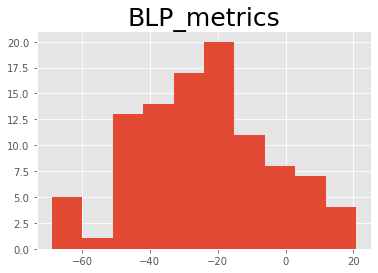

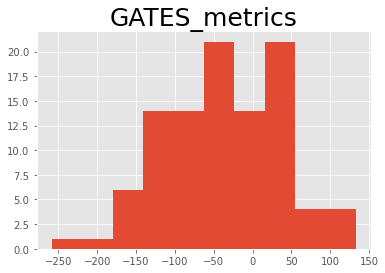

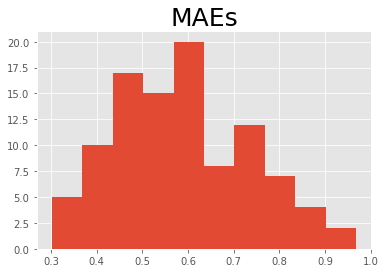

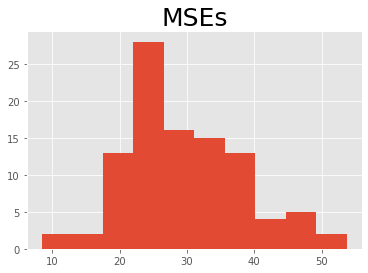

In [63]:
df_metrics =\
        term_paper_main_func_compare_two_models_PAPER_ALGO(model0_A = lgbm0_tune_MSE, model1_A = lgbm1_tune_Lambda_hat, 
                                                model0_B = lgbm0_tune_MSE, model1_B = lgbm1_tune_MSE,
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

In [64]:
lgbm1_tune_MSE.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.0001,
 'min_split_gain': 0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 20,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': False,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [65]:
lgbm1_tune_Lambda_hat.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.0001,
 'min_split_gain': 0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 20,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# 4) Baseline models and estimations to compare previous results with 

# Note: even if p > n like in this case, LinearRegression works!!!! I think this is so, because instead of inverting matrices, there is kinda gradient descent/Adam algorithm!!!

## a) Baseline model (linear regression), mechanism like in the paper and in the code above

In [66]:
linreg0 = LinearRegression()
linreg1 = LinearRegression()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.94it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1682.206460,30129.008040,20.444320,703.784480,1734.469780,0.917590,0.932020
std,165.400176,502.240696,0.496683,31.550548,66.730031,0.062811,0.030762
min,1231.668000,28752.632000,19.471000,636.644000,1606.001000,0.743000,0.864000
25%,1584.969750,29807.703250,20.088250,680.599250,1686.383000,0.879000,0.911000
50%,1702.463500,30206.562000,20.392500,700.126500,1734.903500,0.924500,0.932000
75%,1772.399500,30438.468500,20.751500,719.638750,1768.119750,0.953000,0.953500
max,2126.072000,31440.471000,21.791000,805.991000,1890.761000,1.093000,1.021000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,116.588,102.871,130.530,105.488,100.899,110.192
G2,151.578,141.799,161.336,150.437,149.602,151.251
G3,169.203,159.083,178.937,170.516,169.791,171.236
G4,187.096,176.315,198.179,192.909,191.939,193.911
G5,224.008,209.511,238.493,239.166,235.332,243.026


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,116.588,102.871,130.530,105.488,100.899,110.192
x1,1.341,1.198,1.482,1.055,0.906,1.204
x2,-1.987,-2.278,-1.695,-2.206,-2.493,-1.920
x3,10.545,10.326,10.760,10.351,10.138,10.563
x4,11.537,11.185,11.889,10.832,10.530,11.135
x5,39.600,38.761,40.445,38.304,37.543,39.074
x6,-7.094,-8.020,-6.161,-7.041,-7.950,-6.125
x7,0.397,0.093,0.697,0.260,-0.054,0.575
x8,0.379,0.310,0.448,0.393,0.326,0.461
x9,-1.012,-1.139,-0.884,-0.973,-1.100,-0.846


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,224.008,209.511,238.493,239.166,235.332,243.026
x1,0.614,0.471,0.757,0.942,0.793,1.090
x2,-2.122,-2.417,-1.830,-1.883,-2.177,-1.586
x3,11.444,11.229,11.653,11.493,11.275,11.708
x4,5.990,5.699,6.278,5.852,5.527,6.189
x5,29.386,28.625,30.163,29.236,28.399,30.075
x6,-6.816,-7.469,-6.140,-7.287,-8.013,-6.558
x7,-3.153,-3.352,-2.952,-2.796,-3.029,-2.561
x8,0.622,0.567,0.677,0.622,0.568,0.677
x9,-1.043,-1.178,-0.913,-1.043,-1.174,-0.910


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,107.819,87.766,127.978,133.264,127.298,139.188
x1,-0.735,-0.937,-0.532,-0.110,-0.320,0.100
x2,-0.144,-0.559,0.266,0.325,-0.089,0.739
x3,0.897,0.590,1.203,1.138,0.834,1.442
x4,-5.559,-6.012,-5.103,-4.987,-5.424,-4.523
x5,-10.259,-11.395,-9.130,-9.049,-10.183,-7.908
x6,0.159,-0.975,1.303,-0.263,-1.427,0.897
x7,-3.569,-3.924,-3.202,-3.054,-3.445,-2.661
x8,0.237,0.149,0.323,0.229,0.144,0.315
x9,-0.045,-0.223,0.135,-0.075,-0.257,0.109


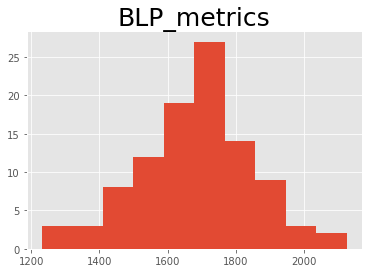

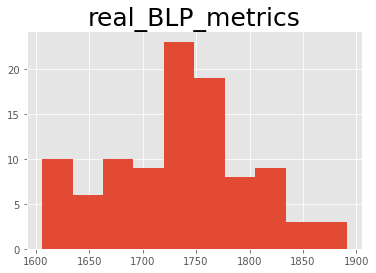

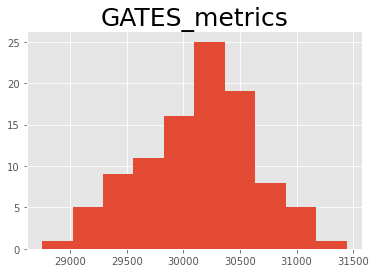

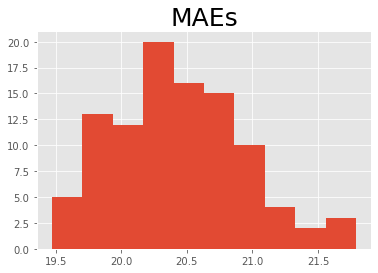

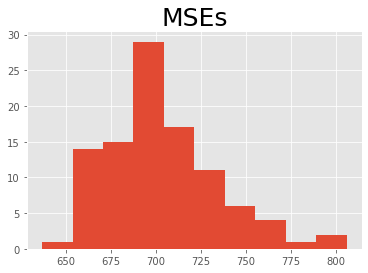

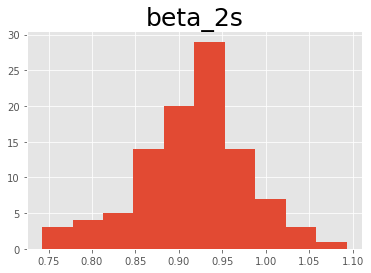

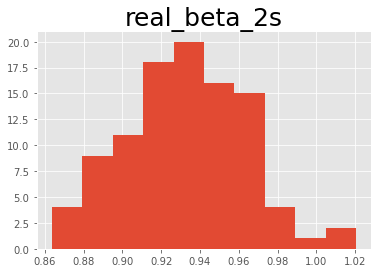

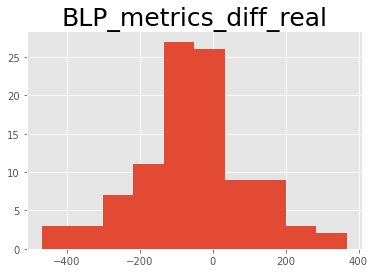

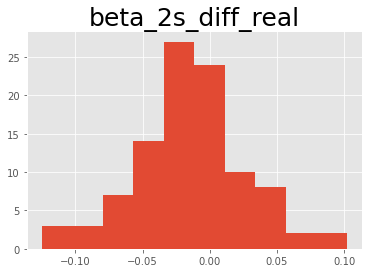

In [67]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = linreg0, model1 = linreg1, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

## b) Naive strategy: just coef to D of simple regression with OOF metrics!!!

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.21it/s]

Metrics table


,MAEs,MSEs
count,100.000000,100.000000
mean,36.034640,2404.872710
std,0.504596,73.334139
min,34.908000,2219.499000
25%,35.618750,2352.045250
50%,36.049500,2405.735500
75%,36.422750,2461.181000
max,37.386000,2593.085000


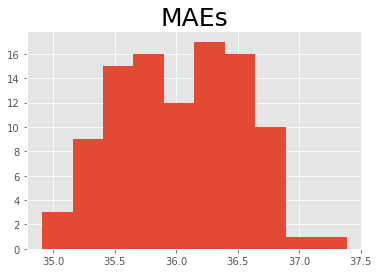

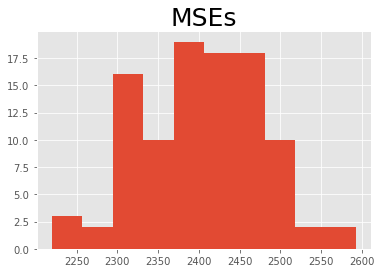

In [68]:
df_metrics =\
        term_paper_main_func_easy_baseline(df = df.copy(), n_splits = 100, extended = True)